# Cluster Factor Experiment

This notebook runs the cluster factor experiment with comprehensive logging.

## Setup
- Loads from existing `agent.pickle` file
- Supports node reduction for local testing (set `reduce_nodes=0.01` for 1%)
- Comprehensive logging writes directly to disk
- Produces same output format as existing experiments


## Summary of Changes

- **Weight Equation Update:** Neighbor weights now include a lifestyle cluster factor, allowing different-cluster pairs to receive reduced influence (configurable per experiment).
- **Streaming Logging:** Introduced a disk-based logger using Python's standard `logging` module with structured JSON output + CSV so weight calculations and iteration stats land in `simulation_logs_*` folders without consuming memory.
- **Pickle Loading & Node Reduction:** The experiment loads the existing `agent.pickle` network and can reduce node count (e.g., 1%) for quick local testing before a full run.
- **Notebook Controls:** This notebook wraps experiment execution, log analysis, and plotting so everything can be simulated and reviewed from one place.


### Historical Change Timeline

1. **Cluster Similarity Factor (initial update)**
   - `AgentManipulator.weighted_update` multiplies the original spending/household/red-meat weight by a lifestyle-cluster factor.
   - `SimulationConfif` and `RunSimulationCollectData` now accept `cluster_similarity_func`; experiment scripts pass a partial returning 1.0 for same-cluster, configurable value otherwise.
   - Monte Carlo scripts (`MC_cluster_factor.py`) sweep over `cluster_factor_list`, storing results/plots per combination.

2. **Streaming Logging & Pickle Loading (current update)**
   - Added `StreamingLogger` (disk-based CSV logging) and integrated it through `run_cluster_factor_experiment.py` and `AgentManipulator.weighted_update`.
   - Added `NetworkUtils.load_agents_from_pickle` / `reduce_network_size` so every run starts from `agent.pickle` and can downsample to 1% nodes for local smoke tests.
   - Notebook now documents the changes, runs the scaled-down experiment, enumerates produced log files, and visualises weight distributions by iteration.

3. **Notebook Workflow Enhancements**
   - Markdown sections summarise the changes and point to the exact code locations.
   - Analysis cells automatically aggregate all `simulation_logs_*` files, so histograms/statistics update as soon as a new run finishes.



### Directory of Updated Files

| Path | Summary of Change |
|---|---|
| `src/AgentManipulator.py` | Added cluster-aware weight multiplier and optional streaming logger hooks (logger flag checks, iteration IDs). |
| `src/StreamingLogger.py` | Streaming logger writes CSV + structured JSON files using Python's standard `logging` module, captures edge IDs (`node->neighbor`), and supports per-feature toggles. |
| `src/structured_logger.py` | Industry-standard structured JSON logger using Python's `logging` module with `RotatingFileHandler` and proper log levels. |
| `src/NetworkUtils.py` | Provides `load_agents_from_pickle` and `reduce_network_size` so experiments reuse `agent.pickle` and can downsample for local tests. |
| `MC_cluster_factor/run_cluster_factor_experiment.py` | Loads agents from pickle, builds `StreamingLogger` per parameter set, and prints the locations of CSV/JSONL logs. |
| `MC_cluster_factor/run_experiment.ipynb` | Notebook orchestration, inline documentation, log diagnostics, histograms/boxplots, and descriptive statistics for every iteration. |


### File-Level Changes (Precise References)

- `src/AgentManipulator.py`
  - `weighted_update(...)` signature expanded to include `logger` and `iteration_num` (lines ≈186-205).
  - Spending/household/red-meat/cluster similarity product is unchanged, but every logging hook now checks the logger flags so the streaming logger can selectively persist data:
    - Before/after node snapshots call `logger.log_node_state(...)` only when `hasattr(logger, "log_node_states") and logger.log_node_states` (lines ≈237-240 and 317-322).
    - Weight capture calls `logger.log_weight_calculation(...)` guarded by the `log_weights` flag (lines ≈259-272).
    - Influence capture wraps `logger.log_influence(...)` in the `log_influence` flag check (lines ≈320-327).
    - Iteration-level metrics at the top and bottom of the loop call `logger.log_iteration_stats(...)` only when `log_iterations` is enabled (lines ≈220-229 and 345-353).

- `src/StreamingLogger.py`
  - **New file** that streams CSV rows to disk (see class definition starting at line 17).
  - Constructor exposes `log_weights`, `log_node_states`, `log_iterations`, `log_influence` booleans (lines 24-50) so callers can dial in the desired verbosity.
  - Each `log_*` method initialises a CSV `DictWriter`, writes a header once, and flushes regularly: weights (≈84-150), node states (≈152-189), iteration stats (≈191-245), influence traces (≈247-300). `close()` ensures files flush/close even on errors (≈302-324).

- `src/NetworkUtils.py`
  - Added `load_agents_from_pickle(...)` and `reduce_network_size(...)` helpers (top of file) so experiments always start from the same `agent.pickle` and optionally thin the graph (e.g., 1% of nodes for local tests).

- `MC_cluster_factor/run_cluster_factor_experiment.py`
  - When `enable_logging=True`, the loop builds a `StreamingLogger` per `(cluster_factor, lancet_pct)` tuple (lines ≈198-214) and injects it into `SimulationConfif` (lines ≈252-285).
  - After each parameter batch the logger is closed and the target directory is printed (lines ≈313-318).
  - The aggregation section now prints the results path **and** walks `log_dir` to list every `weight_logs_*.csv`, `iteration_logs_*.csv`, and `metadata_*.json` that was produced (lines ≈418-430).

- `MC_cluster_factor/run_experiment.ipynb`
  - New markdown sections (“Summary of Changes”, “Logging Overview”, “Detailed Change Log”) document the code edits directly in the notebook.
  - Analysis cells automatically locate `simulation_logs_*`, load all `weight_logs_*.csv`, report counts, and visualise per-iteration histograms so the logging output is immediately accessible.

These references can be searched directly in the workspace if you need to inspect the exact code blocks.


In [1]:
# Import and setup
import sys
import os
sys.path.insert(0, '../src')

from run_cluster_factor_experiment import run_cluster_factor_experiment
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Set matplotlib for inline plots
%matplotlib inline
plt.style.use('seaborn-v0_8-darkgrid')


## Run Experiment

### Local Testing (1% of nodes)
Use this to test before sending to cluster:


In [2]:
# LOCAL TESTING - 1% of nodes
results_local = run_cluster_factor_experiment(
    pickle_path="/Users/mimuw2022/Documents/GitHub/Social_Tipping_Point/simulation/montecarlosim/output_and_log/agent.pickle",  # Adjust path as needed
    reduce_nodes=0.01,  # 1% for local testing
    cluster_factor_list=(0.1, 0.25, 0.5),  # Fewer factors for testing
    n_runs=3,  # Single run for testing
    enable_logging=True,
    log_dir="simulation_logs_local",
    output_dir="MC_runs_local_test"
)

print("\nLocal test complete!")


LOADING AGENTS FROM PICKLE
Loading agents from /Users/mimuw2022/Documents/GitHub/Social_Tipping_Point/simulation/montecarlosim/output_and_log/agent.pickle...
Reducing network from 81563 nodes to 815 nodes (1.0%)...
Reduced network: 815 nodes, 71 edges

Network statistics:
  n_nodes: 815
  n_edges: 71
  n_static: 0
  n_dynamic: 815
  avg_degree: 0.17423312883435582

STARTING MONTE CARLO RUNS

RUN 1/3

  cluster_factor=0.1, random=True, cluster=1
    Running 8 parameter combinations...
parallelparallelparallelparallelparallelparallelparallelparallelparallelparallel
Processing: alpha_0=0.5, alpha=0.3, beta=5.0, sit=0.005, x=39
Processing: alpha_0=0.5, alpha=0.3, beta=5.0, sit=0.005, x=123
Processing: alpha_0=0.5, alpha=0.3, beta=5.0, sit=0.005, x=0
Processing: alpha_0=0.5, alpha=0.3, beta=5.0, sit=0.005, x=481
Processing: alpha_0=0.5, alpha=0.3, beta=5.0, sit=0.005, x=5
Processing: alpha_0=0.5, alpha=0.3, beta=5.0, sit=0.005, x=276
Processing: alpha_0=0.5, alpha=0.3, beta=5.0, sit=0.005, 

/Users/mimuw2022/Documents/GitHub/Social_Tipping_Point/simulation/montecarlosim/MC_cluster_factor/run_cluster_factor_experiment.py:66: RuntimeWarning: overflow encountered in exp
  re1 = 1 - (1 + np.exp(scaling_param * (x2 - x1) / x1)) ** (-1 / scaling_param)


    Logs saved under: simulation_logs_local_20251109_235842/run1_cf0.1_randTrue_q1
    Completed in 0.0 minutes

  cluster_factor=0.25, random=True, cluster=1
    Running 8 parameter combinations...
parallelparallelparallelparallelparallelparallelparallelparallelparallelparallel
Processing: alpha_0=0.5, alpha=0.3, beta=5.0, sit=0.005, x=0
Processing: alpha_0=0.5, alpha=0.3, beta=5.0, sit=0.005, x=5
Processing: alpha_0=0.5, alpha=0.3, beta=5.0, sit=0.005, x=39
Processing: alpha_0=0.5, alpha=0.3, beta=5.0, sit=0.005, x=124
Processing: alpha_0=0.5, alpha=0.3, beta=5.0, sit=0.005, x=273
Processing: alpha_0=0.5, alpha=0.3, beta=5.0, sit=0.005, x=480
Processing: alpha_0=0.5, alpha=0.3, beta=5.0, sit=0.005, x=696
Processing: alpha_0=0.5, alpha=0.3, beta=5.0, sit=0.005, x=815
    Logs saved under: simulation_logs_local_20251109_235842/run1_cf0.25_randTrue_q1
    Completed in 0.0 minutes

  cluster_factor=0.5, random=True, cluster=1
    Running 8 parameter combinations...
parallelparallelparall

/Users/mimuw2022/Documents/GitHub/Social_Tipping_Point/simulation/montecarlosim/MC_cluster_factor/run_cluster_factor_experiment.py:66: RuntimeWarning: overflow encountered in exp
  re1 = 1 - (1 + np.exp(scaling_param * (x2 - x1) / x1)) ** (-1 / scaling_param)


    Logs saved under: simulation_logs_local_20251109_235842/run2_cf0.1_randTrue_q1
    Completed in 0.0 minutes

  cluster_factor=0.25, random=True, cluster=1
    Running 8 parameter combinations...
parallelparallelparallelparallelparallelparallelparallelparallelparallelparallel
Processing: alpha_0=0.5, alpha=0.3, beta=5.0, sit=0.005, x=0
Processing: alpha_0=0.5, alpha=0.3, beta=5.0, sit=0.005, x=5
Processing: alpha_0=0.5, alpha=0.3, beta=5.0, sit=0.005, x=39
Processing: alpha_0=0.5, alpha=0.3, beta=5.0, sit=0.005, x=123
Processing: alpha_0=0.5, alpha=0.3, beta=5.0, sit=0.005, x=279
Processing: alpha_0=0.5, alpha=0.3, beta=5.0, sit=0.005, x=488
Processing: alpha_0=0.5, alpha=0.3, beta=5.0, sit=0.005, x=815
Processing: alpha_0=0.5, alpha=0.3, beta=5.0, sit=0.005, x=701


/Users/mimuw2022/Documents/GitHub/Social_Tipping_Point/simulation/montecarlosim/MC_cluster_factor/run_cluster_factor_experiment.py:66: RuntimeWarning: overflow encountered in exp
  re1 = 1 - (1 + np.exp(scaling_param * (x2 - x1) / x1)) ** (-1 / scaling_param)
/Users/mimuw2022/Documents/GitHub/Social_Tipping_Point/simulation/montecarlosim/MC_cluster_factor/run_cluster_factor_experiment.py:66: RuntimeWarning: overflow encountered in exp
  re1 = 1 - (1 + np.exp(scaling_param * (x2 - x1) / x1)) ** (-1 / scaling_param)


    Logs saved under: simulation_logs_local_20251109_235842/run2_cf0.25_randTrue_q1
    Completed in 0.0 minutes

  cluster_factor=0.5, random=True, cluster=1
    Running 8 parameter combinations...
parallelparallelparallelparallelparallelparallelparallelparallelparallelparallel
Processing: alpha_0=0.5, alpha=0.3, beta=5.0, sit=0.005, x=5
Processing: alpha_0=0.5, alpha=0.3, beta=5.0, sit=0.005, x=0
Processing: alpha_0=0.5, alpha=0.3, beta=5.0, sit=0.005, x=36
Processing: alpha_0=0.5, alpha=0.3, beta=5.0, sit=0.005, x=121
Processing: alpha_0=0.5, alpha=0.3, beta=5.0, sit=0.005, x=278
Processing: alpha_0=0.5, alpha=0.3, beta=5.0, sit=0.005, x=489
Processing: alpha_0=0.5, alpha=0.3, beta=5.0, sit=0.005, x=709
Processing: alpha_0=0.5, alpha=0.3, beta=5.0, sit=0.005, x=815
    Logs saved under: simulation_logs_local_20251109_235842/run2_cf0.5_randTrue_q1
    Completed in 0.0 minutes

  Saved run 2 results to MC_runs_local_test/run_02/MC_cluster_run_02_20251109_235842.xlsx

AGGREGATING RESUL

### Full Run (100% of nodes)
Use this for production/cluster runs:


In [3]:
"""# FULL RUN - 100% of nodes (for cluster)
results_full = run_cluster_factor_experiment(
    pickle_path="../MC_cluster1/agent.pickle",  # Adjust path as needed
    reduce_nodes=None,  # Use full network
    cluster_factor_list=(0.3, 0.5, 0.7, 1.0),
    n_runs=5,  # Multiple runs for statistics
    enable_logging=True,
    log_dir="simulation_logs_full",
    output_dir="MC_runs_full"
)

print("\nFull run complete!")
"""

'# FULL RUN - 100% of nodes (for cluster)\nresults_full = run_cluster_factor_experiment(\n    pickle_path="../MC_cluster1/agent.pickle",  # Adjust path as needed\n    reduce_nodes=None,  # Use full network\n    cluster_factor_list=(0.3, 0.5, 0.7, 1.0),\n    n_runs=5,  # Multiple runs for statistics\n    enable_logging=True,\n    log_dir="simulation_logs_full",\n    output_dir="MC_runs_full"\n)\n\nprint("\nFull run complete!")\n'

## Analyze Results

### Summary Statistics


In [4]:
results_local["df_all"]

,alpha_0,alpha,beta,sit,x,dynamic_initial_total_emission_from_food_mean,dynamic_initial_total_emission_from_food_var,dynamic_initial_total_emission_from_food_total,dynamic_initial_denormalized_total_emission_from_food_mean,dynamic_initial_denormalized_total_emission_from_food_var,...,afterdiet_static_Lamb_and_goat_aggregated_protein_share_var,afterdiet_static_Lamb_and_goat_aggregated_protein_share_total,afterdiet_static_Poultry_aggregated_protein_share_mean,afterdiet_static_Poultry_aggregated_protein_share_var,afterdiet_static_Poultry_aggregated_protein_share_total,cluster number,random,net_final_denormalized_total_emission_from_food_total,avg_emission,x_bin
0,0.5,0.3,5.0,0.005,0,1605.230893,1.253823e+06,1.308263e+06,2899.537069,4.207351e+06,...,0.000000,0.000000,0.000000,0.000000e+00,0.000000,1,True,2.349797e+06,2883.186292,0
1,0.5,0.3,5.0,0.005,5,1606.691491,1.259523e+06,1.301420e+06,2905.890928,4.220769e+06,...,0.000005,0.004959,0.030818,1.504633e-35,0.154091,1,True,2.348584e+06,2881.698176,5
2,0.5,0.3,5.0,0.005,39,1597.110829,1.173318e+06,1.239358e+06,2887.929093,4.109313e+06,...,0.000006,0.084020,0.030818,4.941531e-35,1.201913,1,True,2.326625e+06,2854.754435,39
3,0.5,0.3,5.0,0.005,123,1614.132496,1.337389e+06,1.116980e+06,2913.079288,4.245565e+06,...,0.000006,0.243732,0.030818,1.092215e-34,3.790648,1,True,2.317461e+06,2843.509816,123
4,0.5,0.3,5.0,0.005,276,1601.344062,1.228196e+06,8.631244e+05,2877.232131,4.035780e+06,...,0.000006,0.491752,0.030818,1.087275e-34,8.505845,1,True,2.267780e+06,2782.551880,276
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,0.5,0.3,5.0,0.005,121,1605.919564,1.244196e+06,1.114508e+06,2938.815475,4.336105e+06,...,0.000006,0.273179,0.030818,1.092363e-34,3.729012,1,True,2.310458e+06,2834.918126,121
68,0.5,0.3,5.0,0.005,278,1605.146088,1.355410e+06,8.619634e+05,2919.070102,4.422033e+06,...,0.000006,0.467590,0.030818,1.087247e-34,8.567481,1,True,2.259957e+06,2772.953761,278
69,0.5,0.3,5.0,0.005,489,1580.393887,9.602623e+05,5.152084e+05,2922.196009,3.784699e+06,...,0.000007,0.906066,0.030818,1.085556e-34,15.070138,1,True,2.192807e+06,2690.560172,489
70,0.5,0.3,5.0,0.005,709,1489.147635,1.075541e+06,1.578496e+05,2785.469660,4.197492e+06,...,0.000006,1.247433,0.030818,1.084866e-34,21.850159,1,True,2.098107e+06,2574.363907,709


In [5]:
results_local['df_std']

,x_bin,cluster_factor,lancet_pct,mean,std,low,high
0,0,0.10,0.000000,2883.186292,0.000000,2883.186292,2883.186292
1,0,0.25,0.000000,2883.356122,0.000000,2883.356122,2883.356122
2,0,0.50,0.000000,2883.366783,0.000000,2883.366783,2883.366783
3,5,0.10,0.002915,2881.865458,1.212299,2880.653158,2883.077757
4,5,0.25,0.002915,2880.700213,2.509309,2878.190904,2883.209522
5,5,0.50,0.002915,2881.326888,2.360724,2878.966164,2883.687612
6,36,0.50,0.023324,2875.827310,0.000000,2875.827310,2875.827310
7,38,0.10,0.023324,2880.135084,0.000000,2880.135084,2880.135084
8,38,0.25,0.023324,2866.987318,0.000000,2866.987318,2866.987318
9,39,0.10,0.023324,2861.786125,9.944311,2851.841814,2871.730436


In [6]:
# Display summary statistics
if 'results_full' in locals():
    results = results_full
elif 'results_local' in locals():
    results = results_local
else:
    print("Please run experiment first")
    results = None

if results:
    print("Summary Statistics:")
    print(results['df_std'].head(20))


Summary Statistics:
    x_bin  cluster_factor  lancet_pct         mean       std          low  \
0       0            0.10    0.000000  2883.186292  0.000000  2883.186292   
1       0            0.25    0.000000  2883.356122  0.000000  2883.356122   
2       0            0.50    0.000000  2883.366783  0.000000  2883.366783   
3       5            0.10    0.002915  2881.865458  1.212299  2880.653158   
4       5            0.25    0.002915  2880.700213  2.509309  2878.190904   
5       5            0.50    0.002915  2881.326888  2.360724  2878.966164   
6      36            0.50    0.023324  2875.827310  0.000000  2875.827310   
7      38            0.10    0.023324  2880.135084  0.000000  2880.135084   
8      38            0.25    0.023324  2866.987318  0.000000  2866.987318   
9      39            0.10    0.023324  2861.786125  9.944311  2851.841814   
10     39            0.25    0.023324  2863.655912  6.405677  2857.250235   
11     39            0.50    0.023324  2869.881535  7.29

### Compare Cluster Factors


### Log Folder Locations

Run after experiments to see where weight/iteration logs were written.


In [7]:
# List log folders and files for the most recent run directory
import glob
from pathlib import Path

log_dir = Path("simulation_logs_local")  # change to simulation_logs_full for full runs
if log_dir.exists():
    latest_run_dirs = sorted(log_dir.glob("run*"))
    if latest_run_dirs:
        print("Log directories found:\n")
        for run_path in latest_run_dirs:
            print(f"- {run_path}")
            weight_logs = sorted(run_path.glob("weight_logs_*.csv"))
            iteration_logs = sorted(run_path.glob("iteration_logs_*.csv"))
            print(f"  weight logs ({len(weight_logs)} files):")
            for wf in weight_logs:
                print(f"    {wf.name}")
            print(f"  iteration logs ({len(iteration_logs)} files):")
            for it in iteration_logs:
                print(f"    {it.name}")
            print()
    else:
        print(f"No run directories found inside {log_dir}.")
else:
    print(f"Log directory {log_dir} does not exist yet. Run an experiment first.")


Log directories found:

- simulation_logs_local/run0_cf0.1_randTrue_q1
  weight logs (1 files):
    weight_logs_20251109_092850_774169.csv
  iteration logs (1 files):
    iteration_logs_20251109_092850_774169.csv

- simulation_logs_local/run0_cf0.25_randTrue_q1
  weight logs (1 files):
    weight_logs_20251109_092855_754163.csv
  iteration logs (1 files):
    iteration_logs_20251109_092855_754163.csv

- simulation_logs_local/run0_cf0.5_randTrue_q1
  weight logs (1 files):
    weight_logs_20251109_092900_469789.csv
  iteration logs (1 files):
    iteration_logs_20251109_092900_469789.csv

- simulation_logs_local/run1_cf0.1_randTrue_q1
  weight logs (1 files):
    weight_logs_20251109_092905_296368.csv
  iteration logs (1 files):
    iteration_logs_20251109_092905_296368.csv

- simulation_logs_local/run1_cf0.25_randTrue_q1
  weight logs (1 files):
    weight_logs_20251109_092910_017988.csv
  iteration logs (1 files):
    iteration_logs_20251109_092910_017988.csv

- simulation_logs_local/

### Parameter Combination Outputs

This lists the saved summary files (Excel/plots) for each parameter sweep run.


In [8]:
# Inspect files generated for parameter combinations
from pathlib import Path

output_root = Path("MC_runs_local_test")  # change to MC_runs_full for full runs
if output_root.exists():
    for subdir in sorted(output_root.iterdir()):
        if subdir.is_dir():
            print(f"Directory: {subdir}")
            for file_path in sorted(subdir.iterdir()):
                print(f"  {file_path.name}")
            print()
        else:
            print(f"File: {subdir.name}")
else:
    print(f"Output directory {output_root} does not exist yet. Run an experiment first.")


File: cluster_factor_0.1_1109_0928.png
File: cluster_factor_0.1_20251109_094437.png
File: cluster_factor_0.1_20251109_221456.png
File: cluster_factor_0.1_20251109_235842.png
File: cluster_factor_0.25_1109_0928.png
File: cluster_factor_0.25_20251109_094437.png
File: cluster_factor_0.25_20251109_221456.png
File: cluster_factor_0.25_20251109_235842.png
File: cluster_factor_0.5_1109_0928.png
File: cluster_factor_0.5_20251109_094437.png
File: cluster_factor_0.5_20251109_221456.png
File: cluster_factor_0.5_20251109_235842.png
File: cluster_factor_experiment_summary_1109_0928.xlsx
File: cluster_factor_experiment_summary_20251109_094437.xlsx
File: cluster_factor_experiment_summary_20251109_221456.xlsx
File: cluster_factor_experiment_summary_20251109_235842.xlsx
Directory: MC_runs_local_test/run_00
  MC_cluster_run_00_1109_0928.xlsx
  MC_cluster_run_00_20251109_094437.xlsx
  MC_cluster_run_00_20251109_221456.xlsx
  MC_cluster_run_00_20251109_235842.xlsx

Directory: MC_runs_local_test/run_01
  M

### Logging Overview

- Weight and iteration logs are written under the `simulation_logs_local/` or `simulation_logs_full/` folders, grouped by run, cluster factor, and lancet percentage.
- Each folder contains `weight_logs_*.csv` (per-neighbour weights) plus matching `weight_logs_*.jsonl` structured JSON logs using Python's standard `logging` module, along with iteration/metadata CSV+JSONL outputs; the analysis cells load everything automatically.
- **Weight Log Components**: Each weight calculation now logs both components separately:
  - `component1`: α × spending_similarity × household_similarity
  - `component2`: β × redmeat_similarity × cluster_similarity
  - `final_weight`: component1 + component2
- Edge identification: Each weight entry includes `node`, `neighbor`, `edge_id` (format: "node->neighbor"), `node_cluster`, and `neighbor_cluster` for detailed tracking.
- Adjust `log_dir` in the analysis cells if you want to compare local vs. full runs.


In [9]:
df_std

NameError: name 'df_std' is not defined

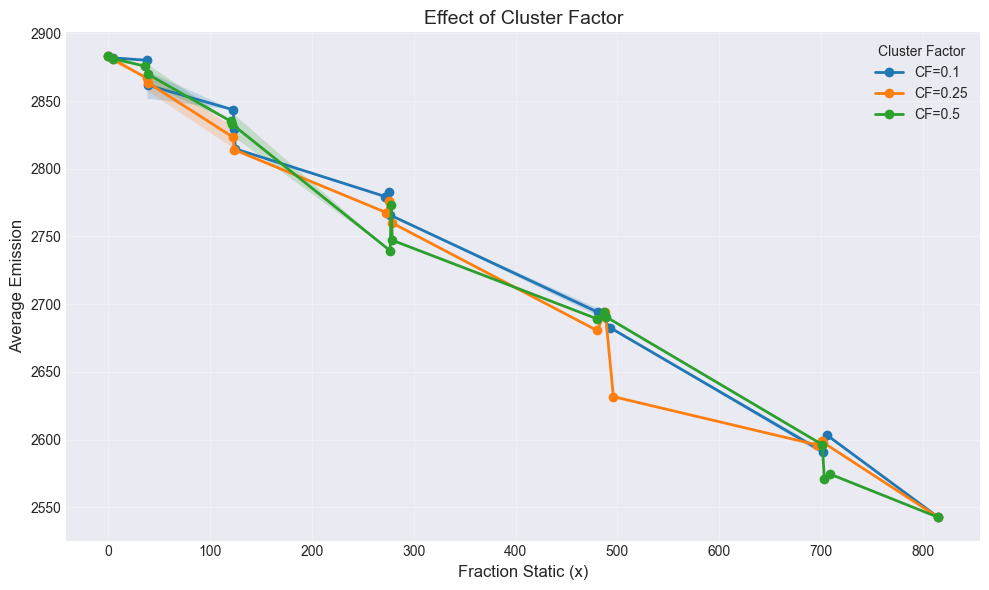

In [10]:
# Compare different cluster factors
if results:
    df_std = results['df_std']
    
    df_plot = df_std
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    for cf in sorted(df_plot['cluster_factor'].unique()):
        df_cf = df_plot[df_plot['cluster_factor'] == cf]
        ax.plot(df_cf['x_bin'], df_cf['mean'], 'o-', label=f'CF={cf}', linewidth=2)
        ax.fill_between(df_cf['x_bin'], df_cf['low'], df_cf['high'], alpha=0.2)
    
    ax.set_xlabel('Fraction Static (x)', fontsize=12)
    ax.set_ylabel('Average Emission', fontsize=12)
    ax.set_title(f'Effect of Cluster Factor', fontsize=14)
    ax.legend(title='Cluster Factor')
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


### Analyze Weight Logs - Histograms by Iteration

Read weight logs and plot histograms of weights for each iteration.

**Note:** The number of weights per iteration depends on:
- Number of edges in the network (each edge contributes 2 weights: node→neighbor and neighbor→node)
- Number of nodes with neighbors (nodes without neighbors have 0 weights)
- Number of static nodes (static nodes don't update, so fewer weights)

With 815 nodes and 71 edges, you'd expect ~142 weights per iteration (71 edges × 2 directions), not 800.


Found 9 weight log file(s)
Loaded 368100 total weight calculations from 9 files
Log directories: ['simulation_logs_local/run0_cf0.1_randTrue_q1', 'simulation_logs_local/run0_cf0.25_randTrue_q1', 'simulation_logs_local/run0_cf0.5_randTrue_q1', 'simulation_logs_local/run1_cf0.1_randTrue_q1', 'simulation_logs_local/run1_cf0.25_randTrue_q1', 'simulation_logs_local/run1_cf0.5_randTrue_q1', 'simulation_logs_local/run2_cf0.1_randTrue_q1', 'simulation_logs_local/run2_cf0.25_randTrue_q1', 'simulation_logs_local/run2_cf0.5_randTrue_q1']
Weight log counts per parameter folder (cluster_factor + lancet_pct):
  run0_cf0.1_randTrue_q1: 1 file(s)
  run0_cf0.25_randTrue_q1: 1 file(s)
  run0_cf0.5_randTrue_q1: 1 file(s)
  run1_cf0.1_randTrue_q1: 1 file(s)
  run1_cf0.25_randTrue_q1: 1 file(s)
  run1_cf0.5_randTrue_q1: 1 file(s)
  run2_cf0.1_randTrue_q1: 1 file(s)
  run2_cf0.25_randTrue_q1: 1 file(s)
  run2_cf0.5_randTrue_q1: 1 file(s)
(Each file contains all 50 iterations for that parameter combination.)

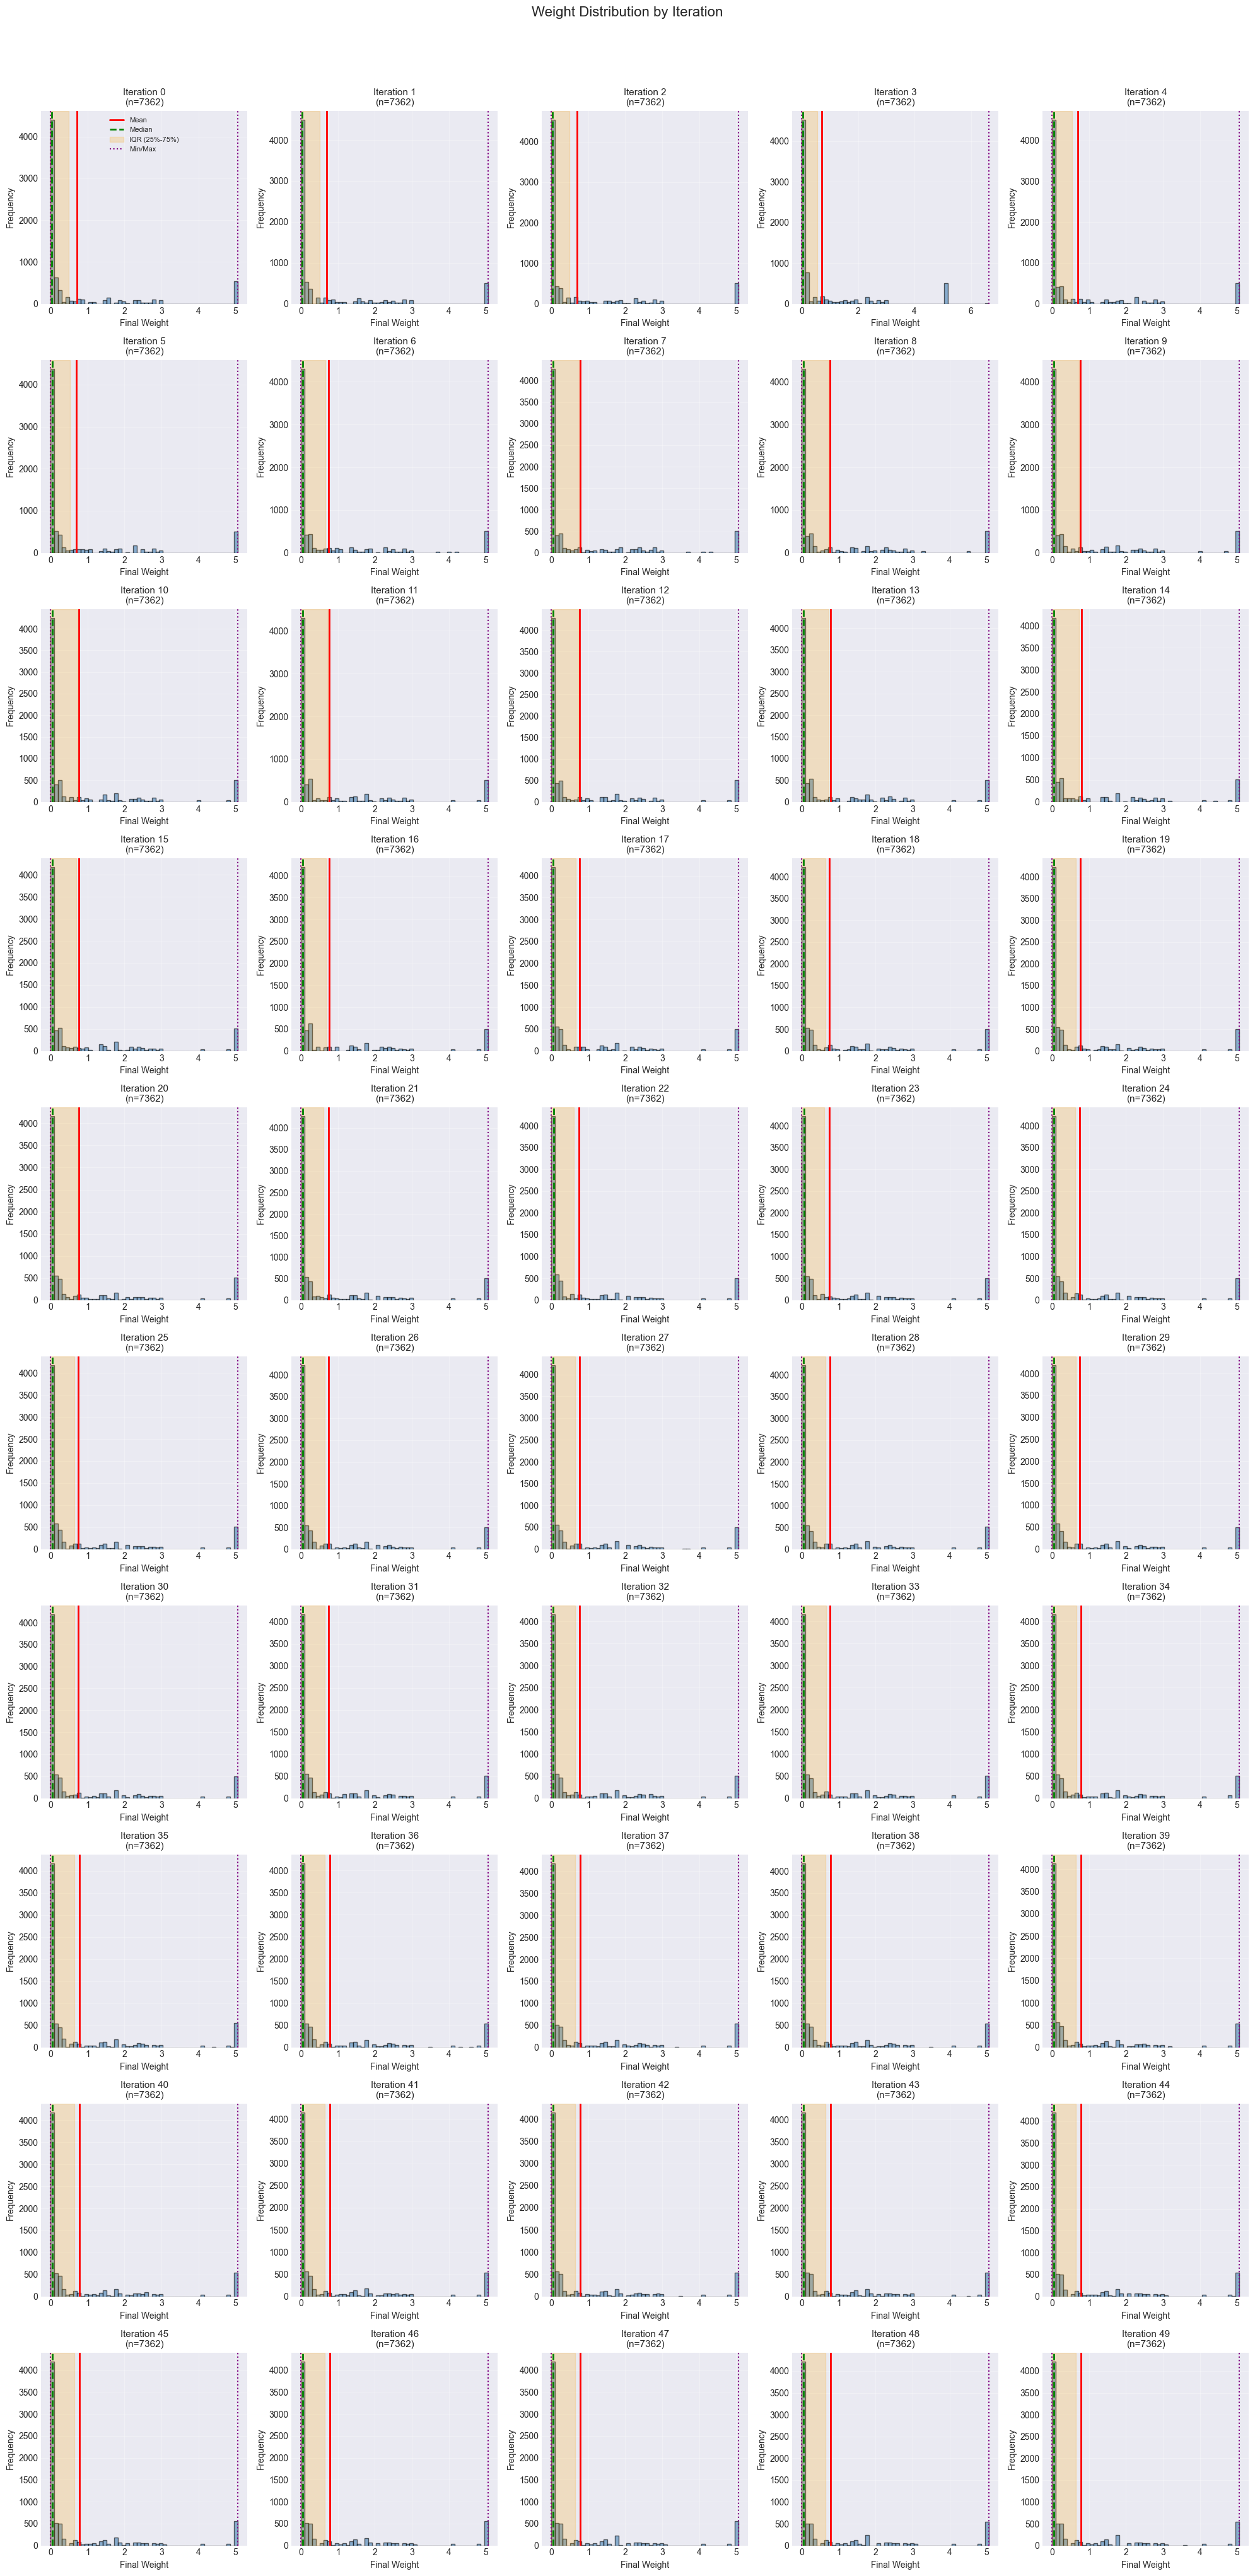

,iteration,count,mean,std,min,q25,median,q75,max
0,0,7362,0.707850,1.412937,1.946935e-07,0.000137,0.036644,0.490585,5.068520
1,1,7362,0.689271,1.381514,1.947975e-07,0.000179,0.035522,0.506043,5.068520
2,2,7362,0.694001,1.382291,1.950073e-07,0.000229,0.034643,0.491373,5.068520
3,3,7362,0.705363,1.395421,1.951131e-07,0.000245,0.041866,0.550458,6.637827
4,4,7362,0.697505,1.381922,1.951131e-07,0.000261,0.041221,0.535795,5.068520
5,5,7362,0.700143,1.380399,1.952195e-07,0.000279,0.046754,0.521125,5.068520
6,6,7362,0.744947,1.410393,1.953266e-07,0.000256,0.046493,0.659617,5.068520
7,7,7362,0.783782,1.431837,1.954343e-07,0.000278,0.051506,0.760472,5.068520
8,8,7362,0.769147,1.423168,1.955426e-07,0.000287,0.045955,0.737256,5.068520
9,9,7362,0.768702,1.429781,1.957611e-07,0.000308,0.049661,0.737465,5.068520


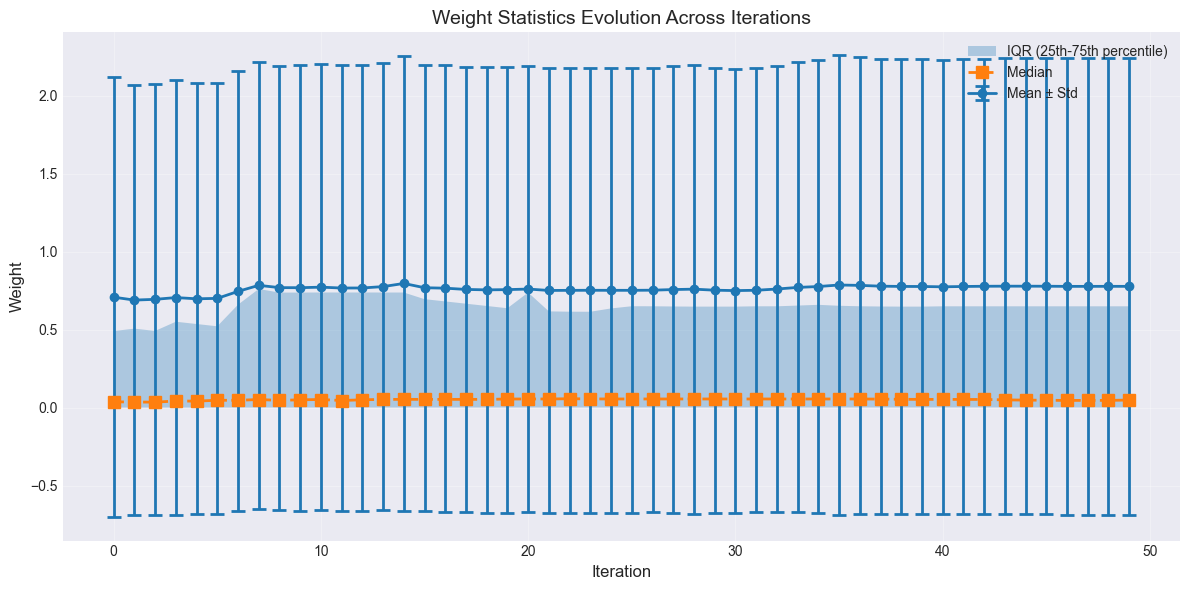

In [11]:
# Read weight logs and plot histograms for each iteration
import glob
from IPython.display import display

# Find weight log files
log_dir = "simulation_logs_local"  # Change to "simulation_logs_full" for full runs
weight_files = glob.glob(os.path.join(log_dir, "run*", "weight_logs_*.csv"))

if weight_files:
    print(f"Found {len(weight_files)} weight log file(s)")
    
    # Load all weight logs and combine into a single DataFrame
    weight_dfs = []
    for weight_file in sorted(weight_files):
        df = pd.read_csv(weight_file)
        df['log_file'] = os.path.basename(weight_file)
        df['log_dir'] = os.path.dirname(weight_file)
        weight_dfs.append(df)
    
    weights_df = pd.concat(weight_dfs, ignore_index=True)
    log_dirs = sorted(set(os.path.dirname(f) for f in weight_files))
    print(f"Loaded {len(weights_df)} total weight calculations from {len(weight_files)} files")
    print(f"Log directories: {log_dirs}")
    from collections import Counter
    dir_counts = Counter(os.path.dirname(f) for f in weight_files)
    print("Weight log counts per parameter folder (cluster_factor + lancet_pct):")
    for dir_path, count in sorted(dir_counts.items()):
        print(f"  {os.path.basename(dir_path)}: {count} file(s)")
    print("(Each file contains all 50 iterations for that parameter combination.)")
    print(f"Iteration range: {weights_df['iteration'].min()} to {weights_df['iteration'].max()} (n={weights_df['iteration'].nunique()})")
    
    # Optional: filter by iteration range (default: all)
    iter_start = weights_df['iteration'].min()
    iter_end = weights_df['iteration'].max()
    
    weights_subset = weights_df[(weights_df['iteration'] >= iter_start) & (weights_df['iteration'] <= iter_end)]
    iterations = sorted(weights_subset['iteration'].unique())
    n_iterations = len(iterations)
    
    counts_per_iter = weights_subset.groupby('iteration')['final_weight'].size().sort_index()
    print("\nWeights logged per iteration (total neighbour weights recorded):")
    print(counts_per_iter.to_string())
    print("Counts can drop in later iterations when a node's total neighbour weight falls below the 1e-2 threshold, so that node is skipped in that step.")
    
    print(f"\nPlotting iterations {iter_start} through {iter_end} ({n_iterations} iterations)")
    
    # Create subplots - arrange in a grid
    n_cols = min(5, n_iterations)  # Max 5 columns
    n_rows = (n_iterations + n_cols - 1) // n_cols  # Ceiling division
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, max(4, 4*n_rows)))
    if n_iterations == 1:
        axes = [axes]
    elif n_rows == 1:
        axes = axes if isinstance(axes, np.ndarray) else [axes]
    else:
        axes = axes.flatten()
    
    iter_stats_records = []
    
    # Plot histogram for each iteration
    for idx, iteration in enumerate(iterations):
        ax = axes[idx] if n_iterations > 1 else axes[0]
        
        # Get weights for this iteration
        iter_weights = weights_subset[weights_subset['iteration'] == iteration]['final_weight']
        
        # Plot histogram (allow matplotlib to determine bin range; no artificial caps)
        ax.hist(iter_weights, bins=50, alpha=0.6, edgecolor='black', color='steelblue')
        ax.set_xlabel('Final Weight', fontsize=10)
        ax.set_ylabel('Frequency', fontsize=10)
        ax.set_title(f'Iteration {iteration}\n(n={len(iter_weights)})', fontsize=11)
        ax.grid(True, alpha=0.3)
        
        # Compute descriptive statistics
        mean_val = iter_weights.mean()
        std_val = iter_weights.std()
        median_val = iter_weights.median()
        q25 = iter_weights.quantile(0.25)
        q75 = iter_weights.quantile(0.75)
        min_val = iter_weights.min()
        max_val = iter_weights.max()
        count_val = len(iter_weights)
        
        iter_stats_records.append({
            'iteration': iteration,
            'count': count_val,
            'mean': mean_val,
            'std': std_val,
            'min': min_val,
            'q25': q25,
            'median': median_val,
            'q75': q75,
            'max': max_val
        })
        
        # Overlay statistics
        ax.axvline(mean_val, color='red', linestyle='-', linewidth=2, label='Mean')
        ax.axvline(median_val, color='green', linestyle='--', linewidth=2, label='Median')
        ax.axvspan(q25, q75, color='orange', alpha=0.2, label='IQR (25%-75%)')
        ax.axvline(min_val, color='purple', linestyle=':', linewidth=1.5, label='Min/Max')
        ax.axvline(max_val, color='purple', linestyle=':', linewidth=1.5)
        
        if idx == 0:
            ax.legend(fontsize=8)
    
    # Hide unused subplots
    for idx in range(n_iterations, len(axes)):
        axes[idx].set_visible(False)
    
    plt.suptitle('Weight Distribution by Iteration', fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()
    
    # Create descriptive statistics table and display it
    stats_df = pd.DataFrame(iter_stats_records)
    stats_df = stats_df[['iteration', 'count', 'mean', 'std', 'min', 'q25', 'median', 'q75', 'max']]
    display(stats_df)
    
    # Evolution plot using descriptive stats
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.errorbar(stats_df['iteration'], stats_df['mean'], yerr=stats_df['std'],
                marker='o', capsize=5, capthick=2, linewidth=2, label='Mean ± Std')
    ax.fill_between(stats_df['iteration'], stats_df['q25'], stats_df['q75'],
                    alpha=0.3, label='IQR (25th-75th percentile)')
    ax.plot(stats_df['iteration'], stats_df['median'], 's--', linewidth=2,
            markersize=8, label='Median')
    ax.set_xlabel('Iteration', fontsize=12)
    ax.set_ylabel('Weight', fontsize=12)
    ax.set_title('Weight Statistics Evolution Across Iterations', fontsize=14)
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
else:
    print(f"No weight log files found in {log_dir}")
    print("\nTo find log files, run:")
    print("  import glob")
    print(f"  glob.glob('{log_dir}/run*/weight_logs_*.csv')")


## Weight Component Analysis

The weight equation is: `w = component1 + component2`

where:
- **component1** = `alpha × spending_sim × household_sim`
- **component2** = `beta × redmeat_sim × cluster_sim`


=== Weight Component Analysis ===

Component 1 (alpha × spending_sim × household_sim):
  Mean: 0.328778
  Std:  0.690742
  Min:  0.000000
  Max:  2.999003

Component 2 (beta × redmeat_sim × cluster_sim):
  Mean: 0.430512
  Std:  1.331157
  Min:  0.000000
  Max:  5.000000

Final Weight (component1 + component2):
  Mean: 0.759290
  Std:  1.435481
  Min:  0.000000
  Max:  6.637827


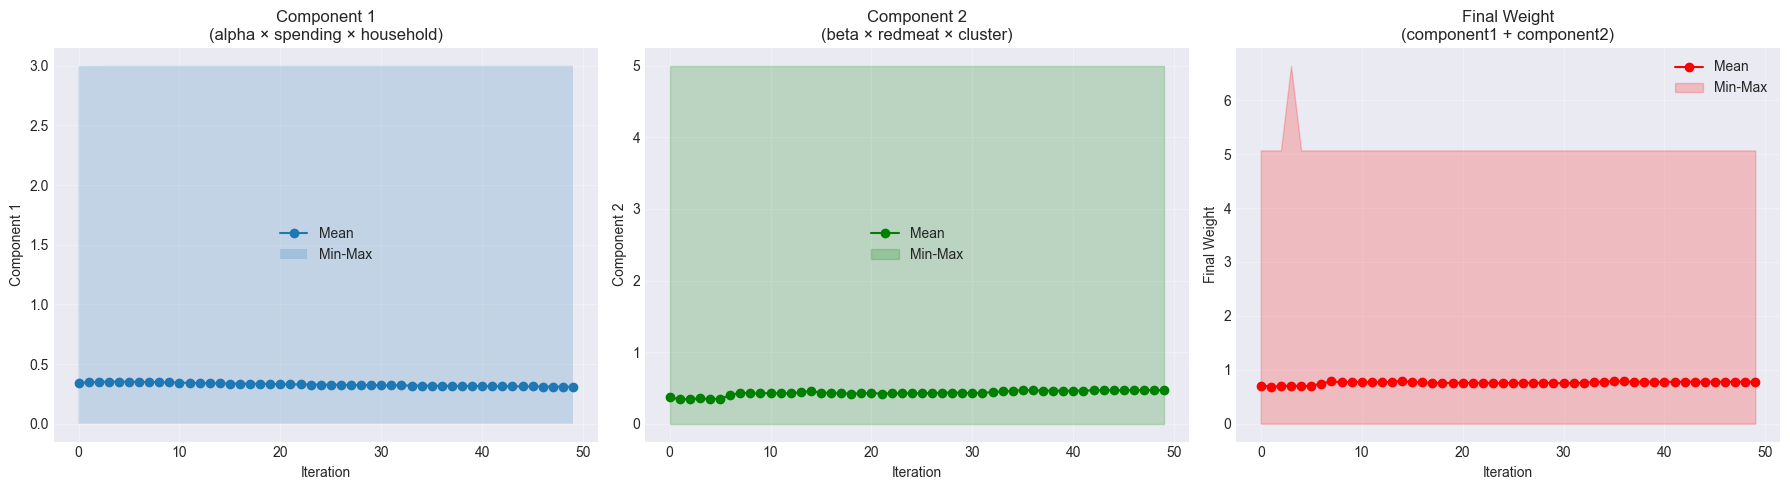

In [12]:
# Analyze weight components
if weight_files and 'component1' in weights_df.columns and 'component2' in weights_df.columns:
    print("=== Weight Component Analysis ===\n")
    
    # Overall statistics
    print("Component 1 (alpha × spending_sim × household_sim):")
    print(f"  Mean: {weights_df['component1'].mean():.6f}")
    print(f"  Std:  {weights_df['component1'].std():.6f}")
    print(f"  Min:  {weights_df['component1'].min():.6f}")
    print(f"  Max:  {weights_df['component1'].max():.6f}")
    
    print(f"\nComponent 2 (beta × redmeat_sim × cluster_sim):")
    print(f"  Mean: {weights_df['component2'].mean():.6f}")
    print(f"  Std:  {weights_df['component2'].std():.6f}")
    print(f"  Min:  {weights_df['component2'].min():.6f}")
    print(f"  Max:  {weights_df['component2'].max():.6f}")
    
    print(f"\nFinal Weight (component1 + component2):")
    print(f"  Mean: {weights_df['final_weight'].mean():.6f}")
    print(f"  Std:  {weights_df['final_weight'].std():.6f}")
    print(f"  Min:  {weights_df['final_weight'].min():.6f}")
    print(f"  Max:  {weights_df['final_weight'].max():.6f}")
    
    # Plot component evolution
    comp_stats = weights_df.groupby('iteration').agg({
        'component1': ['mean', 'min', 'max'],
        'component2': ['mean', 'min', 'max'],
        'final_weight': ['mean', 'min', 'max']
    }).reset_index()
    comp_stats.columns = ['_'.join(col).strip('_') if col[1] else col[0] for col in comp_stats.columns.values]
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # Component 1
    ax1 = axes[0]
    ax1.plot(comp_stats['iteration'], comp_stats['component1_mean'], 'o-', label='Mean')
    ax1.fill_between(comp_stats['iteration'], comp_stats['component1_min'], 
                     comp_stats['component1_max'], alpha=0.2, label='Min-Max')
    ax1.set_xlabel('Iteration')
    ax1.set_ylabel('Component 1')
    ax1.set_title('Component 1\n(alpha × spending × household)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Component 2
    ax2 = axes[1]
    ax2.plot(comp_stats['iteration'], comp_stats['component2_mean'], 'o-', label='Mean', color='green')
    ax2.fill_between(comp_stats['iteration'], comp_stats['component2_min'], 
                     comp_stats['component2_max'], alpha=0.2, label='Min-Max', color='green')
    ax2.set_xlabel('Iteration')
    ax2.set_ylabel('Component 2')
    ax2.set_title('Component 2\n(beta × redmeat × cluster)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Final weight
    ax3 = axes[2]
    ax3.plot(comp_stats['iteration'], comp_stats['final_weight_mean'], 'o-', label='Mean', color='red')
    ax3.fill_between(comp_stats['iteration'], comp_stats['final_weight_min'], 
                     comp_stats['final_weight_max'], alpha=0.2, label='Min-Max', color='red')
    ax3.set_xlabel('Iteration')
    ax3.set_ylabel('Final Weight')
    ax3.set_title('Final Weight\n(component1 + component2)')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
elif weight_files:
    print("⚠️  Component columns not found. Re-run experiment to generate component logs.")

## Component 2 Contribution Ratio

This shows the ratio `component2 / final_weight` for each iteration, revealing how much of the final weight comes from the red meat and cluster similarity component.


Plotting component2/weight ratio for 50 iterations



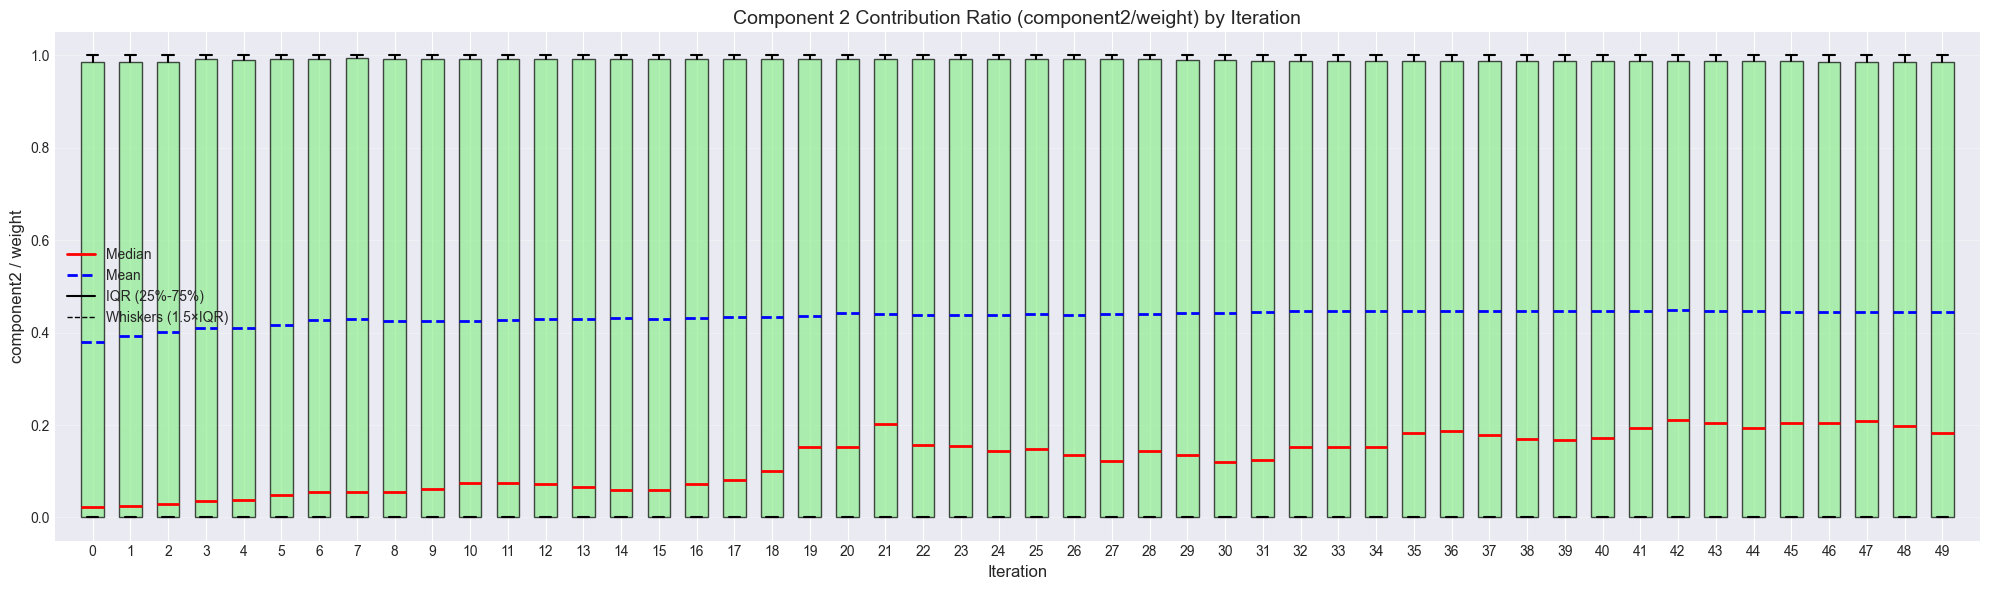

Statistics for first 3 iterations:

Iteration 0:
  Count:  7362
  Mean:   0.3802
  Median: 0.0223
  Std:    0.4521
  Min:    0.0000
  Q25:    0.0002
  Q75:    0.9865
  Max:    1.0000

Iteration 1:
  Count:  7362
  Mean:   0.3935
  Median: 0.0246
  Std:    0.4579
  Min:    0.0000
  Q25:    0.0002
  Q75:    0.9865
  Max:    1.0000

Iteration 2:
  Count:  7362
  Mean:   0.4013
  Median: 0.0288
  Std:    0.4613
  Min:    0.0000
  Q25:    0.0002
  Q75:    0.9865
  Max:    1.0000

Overall Statistics (across all iterations):
Count:  368100
Mean:   0.4350
Median: 0.0997
Std:    0.4615
Min:    0.0000
Q25:    0.0005
Q75:    0.9870
Max:    1.0000


In [13]:
# Plot boxplot of component2/weight ratio for each iteration
if weight_files and 'component1' in weights_df.columns and 'component2' in weights_df.columns:
    # Calculate the ratio, handling division by zero
    weights_df['component2_ratio'] = weights_df['component2'] / weights_df['final_weight'].replace(0, np.nan)
    
    # Get unique iterations
    iterations = sorted(weights_df['iteration'].unique())
    n_iterations = len(iterations)
    
    print(f"Plotting component2/weight ratio for {n_iterations} iterations\n")
    
    # Prepare data for boxplot
    ratio_data = []
    for iteration in iterations:
        iter_ratios = weights_df[weights_df['iteration'] == iteration]['component2_ratio'].dropna()
        ratio_data.append(iter_ratios)
    
    # Create boxplot
    fig, ax = plt.subplots(figsize=(20, 6))
    
    bp = ax.boxplot(ratio_data, positions=iterations, widths=0.6, patch_artist=True,
                    showmeans=True, meanline=True,
                    boxprops=dict(facecolor='lightgreen', alpha=0.7),
                    medianprops=dict(color='red', linewidth=2),
                    meanprops=dict(color='blue', linewidth=2, linestyle='--'),
                    whiskerprops=dict(linewidth=1.5),
                    capprops=dict(linewidth=1.5))
    
    ax.set_xlabel('Iteration', fontsize=12)
    ax.set_ylabel('component2 / weight', fontsize=12)
    ax.set_title('Component 2 Contribution Ratio (component2/weight) by Iteration', fontsize=14)
    ax.grid(True, alpha=0.3, axis='y')
    ax.set_xlim(-1, max(iterations) + 1)
    
    # Add legend
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], color='red', linewidth=2, label='Median'),
        Line2D([0], [0], color='blue', linewidth=2, linestyle='--', label='Mean'),
        Line2D([0], [0], color='black', linewidth=1.5, label='IQR (25%-75%)'),
        Line2D([0], [0], color='black', linewidth=1, linestyle='--', label='Whiskers (1.5×IQR)')
    ]
    ax.legend(handles=legend_elements, loc='best', fontsize=10)
    
    plt.tight_layout()
    plt.show()
    
    # Print statistics for first few iterations
    print("Statistics for first 3 iterations:")
    print("="*80)
    for idx, iteration in enumerate(iterations[:3]):
        iter_ratios = ratio_data[idx]
        print(f"\nIteration {iteration}:")
        print(f"  Count:  {len(iter_ratios)}")
        print(f"  Mean:   {iter_ratios.mean():.4f}")
        print(f"  Median: {iter_ratios.median():.4f}")
        print(f"  Std:    {iter_ratios.std():.4f}")
        print(f"  Min:    {iter_ratios.min():.4f}")
        print(f"  Q25:    {iter_ratios.quantile(0.25):.4f}")
        print(f"  Q75:    {iter_ratios.quantile(0.75):.4f}")
        print(f"  Max:    {iter_ratios.max():.4f}")
    
    # Summary statistics across all iterations
    print("\n" + "="*80)
    print("Overall Statistics (across all iterations):")
    print("="*80)
    overall_ratios = weights_df['component2_ratio'].dropna()
    print(f"Count:  {len(overall_ratios)}")
    print(f"Mean:   {overall_ratios.mean():.4f}")
    print(f"Median: {overall_ratios.median():.4f}")
    print(f"Std:    {overall_ratios.std():.4f}")
    print(f"Min:    {overall_ratios.min():.4f}")
    print(f"Q25:    {overall_ratios.quantile(0.25):.4f}")
    print(f"Q75:    {overall_ratios.quantile(0.75):.4f}")
    print(f"Max:    {overall_ratios.max():.4f}")
    
elif weight_files:
    print("⚠️  Component columns not found. Re-run experiment to generate component logs.")


Plotting component2/weight ratio for 50 iterations

Iteration 0:
  Mean: 0.3802
  Std:  0.4521
  Min:  0.0000
  Max:  1.0000

Iteration 1:
  Mean: 0.3935
  Std:  0.4579
  Min:  0.0000
  Max:  1.0000

Iteration 2:
  Mean: 0.4013
  Std:  0.4613
  Min:  0.0000
  Max:  1.0000



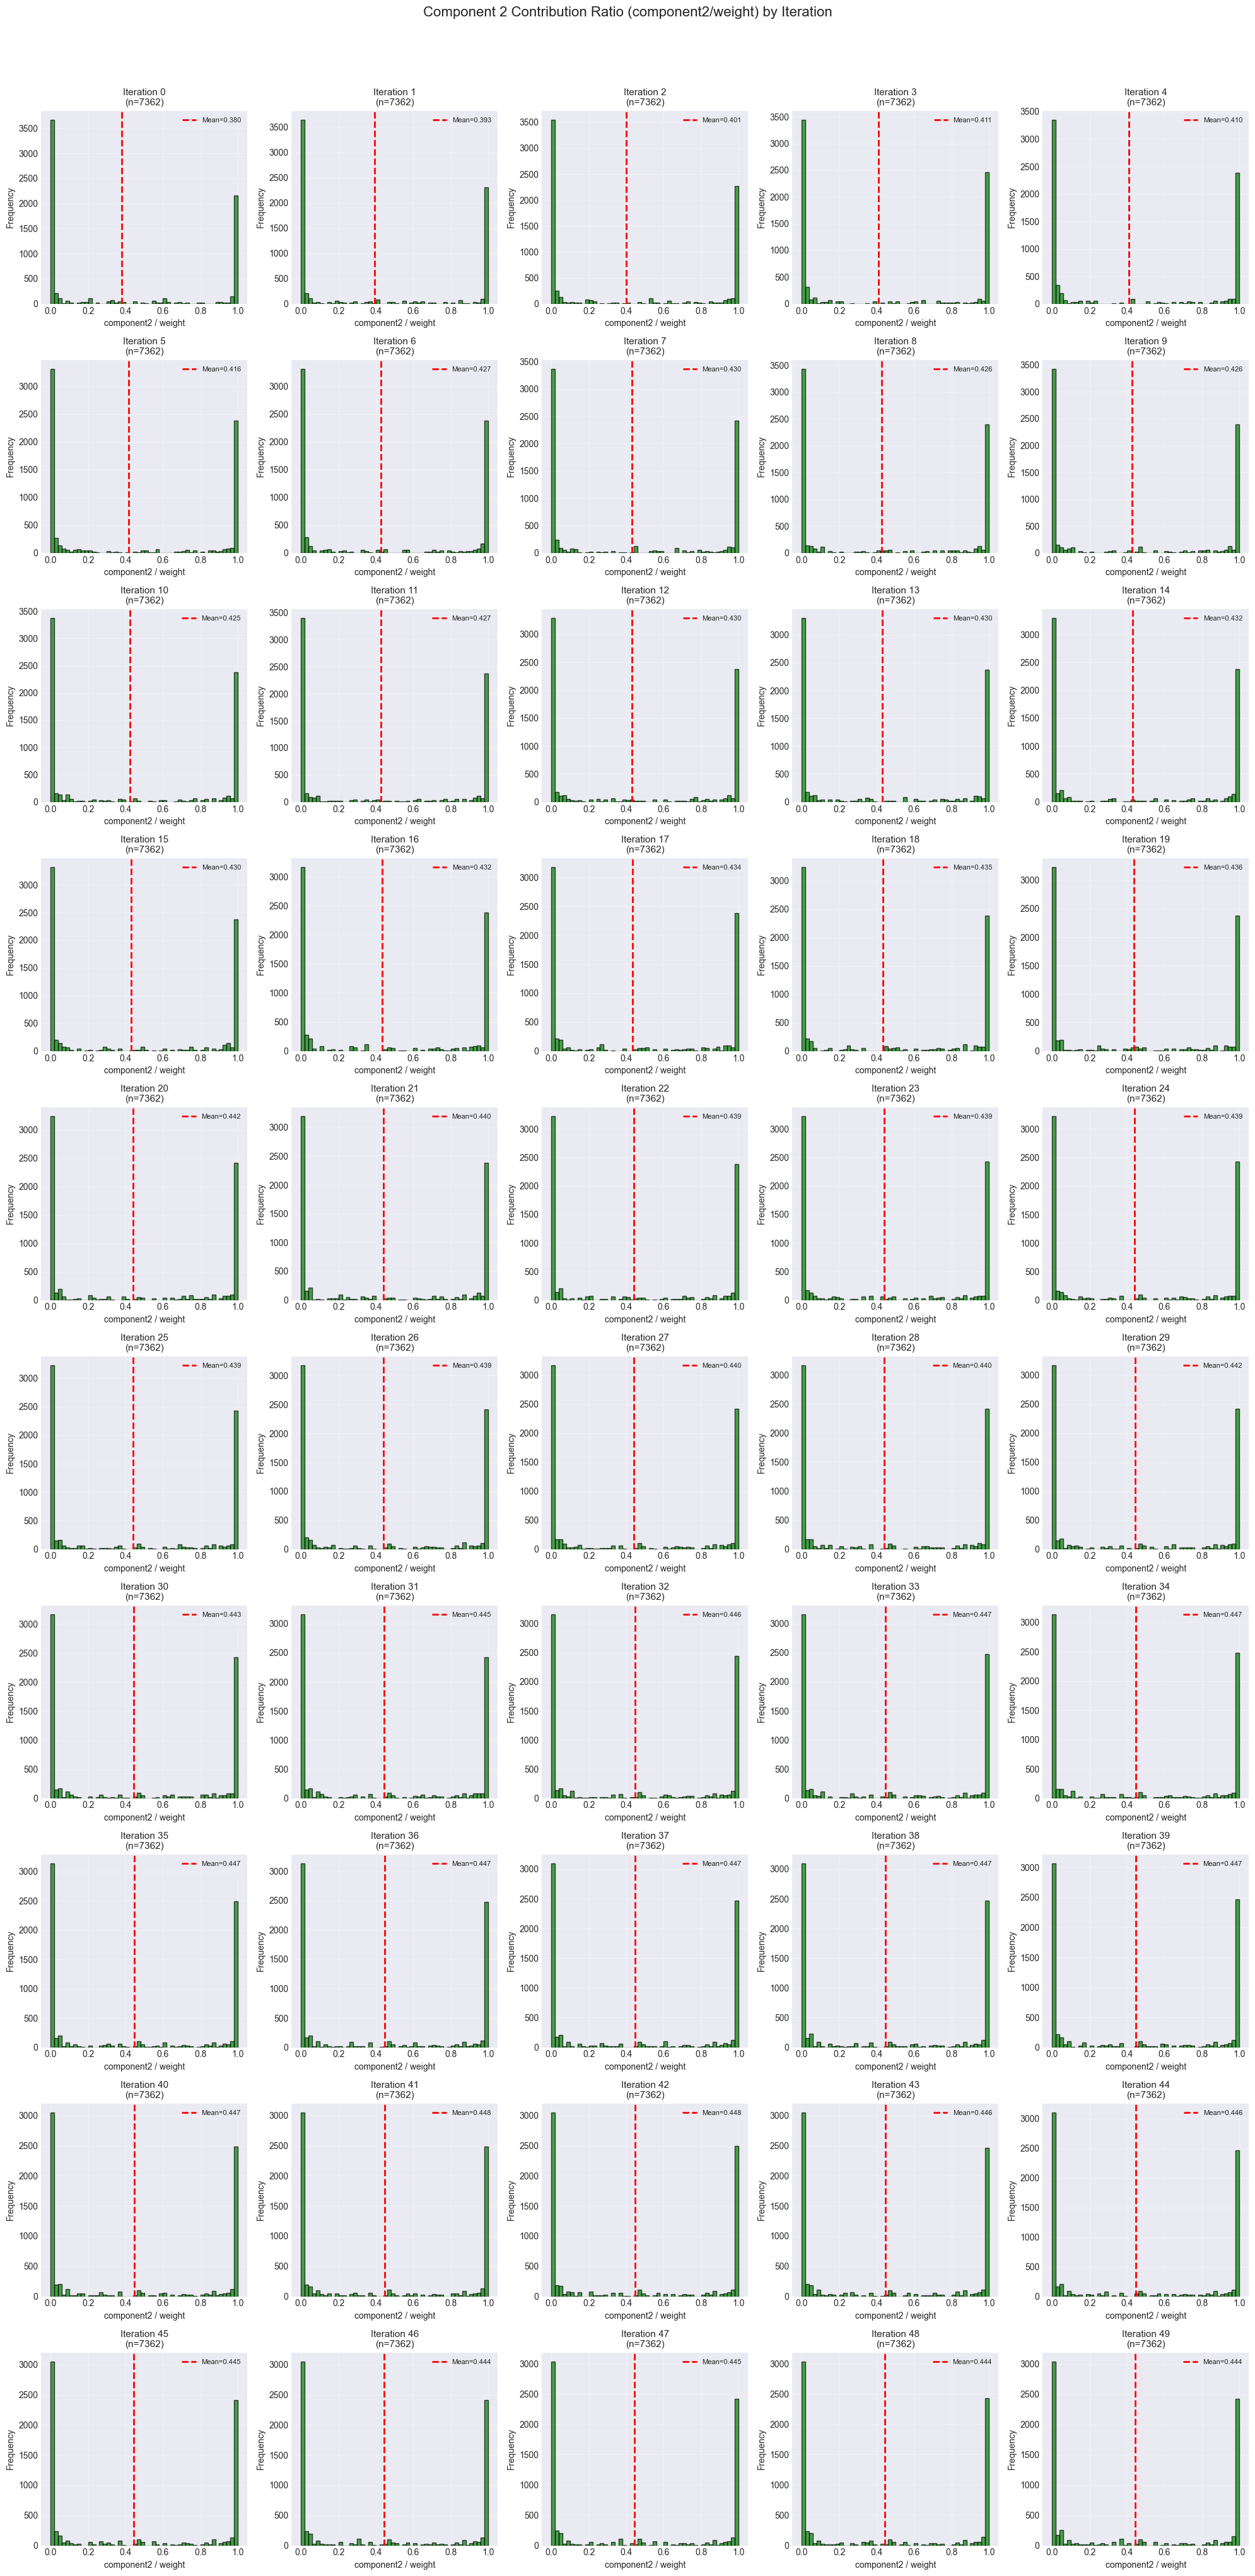


Overall Statistics (across all iterations):
Mean:   0.4350
Std:    0.4615
Median: 0.0997
Min:    0.0000
Max:    1.0000


In [15]:
# Plot histogram of component2/weight ratio for each iteration
if weight_files and 'component1' in weights_df.columns and 'component2' in weights_df.columns:
    # Calculate the ratio, handling division by zero
    weights_df['component2_ratio'] = weights_df['component2'] / weights_df['final_weight'].replace(0, np.nan)
    
    # Get unique iterations
    iterations = sorted(weights_df['iteration'].unique())
    n_iterations = len(iterations)
    
    # Create subplots - arrange in a grid
    n_cols = min(5, n_iterations)
    n_rows = (n_iterations + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, max(4, 4*n_rows)))
    if n_iterations == 1:
        axes = [axes]
    elif n_rows == 1:
        axes = axes if isinstance(axes, np.ndarray) else [axes]
    else:
        axes = axes.flatten()
    
    print(f"Plotting component2/weight ratio for {n_iterations} iterations\n")
    
    # Plot histogram for each iteration
    for idx, iteration in enumerate(iterations):
        ax = axes[idx] if n_iterations > 1 else axes[0]
        
        # Get ratios for this iteration (exclude NaN values)
        iter_ratios = weights_df[weights_df['iteration'] == iteration]['component2_ratio'].dropna()
        
        # Plot histogram
        ax.hist(iter_ratios, bins=50, alpha=0.7, edgecolor='black', color='green')
        ax.set_xlabel('component2 / weight', fontsize=10)
        ax.set_ylabel('Frequency', fontsize=10)
        ax.set_title(f'Iteration {iteration}\n(n={len(iter_ratios)})', fontsize=11)
        ax.grid(True, alpha=0.3)
        
        # Add mean line
        mean_ratio = iter_ratios.mean()
        ax.axvline(mean_ratio, color='red', linestyle='--', linewidth=2, label=f'Mean={mean_ratio:.3f}')
        ax.legend(fontsize=8)
        
        # Print statistics for first few iterations
        if idx < 3:
            print(f"Iteration {iteration}:")
            print(f"  Mean: {mean_ratio:.4f}")
            print(f"  Std:  {iter_ratios.std():.4f}")
            print(f"  Min:  {iter_ratios.min():.4f}")
            print(f"  Max:  {iter_ratios.max():.4f}")
            print()
    
    # Hide unused subplots
    for idx in range(n_iterations, len(axes)):
        axes[idx].set_visible(False)
    
    plt.suptitle('Component 2 Contribution Ratio (component2/weight) by Iteration', fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()
    
    # Summary statistics across all iterations
    print("\n" + "="*80)
    print("Overall Statistics (across all iterations):")
    print("="*80)
    overall_ratios = weights_df['component2_ratio'].dropna()
    print(f"Mean:   {overall_ratios.mean():.4f}")
    print(f"Std:    {overall_ratios.std():.4f}")
    print(f"Median: {overall_ratios.median():.4f}")
    print(f"Min:    {overall_ratios.min():.4f}")
    print(f"Max:    {overall_ratios.max():.4f}")
    
elif weight_files:
    print("⚠️  Component columns not found. Re-run experiment to generate component logs.")


### Boxplot of Weight Distributions per Iteration

The boxplot below summarises the distribution of neighbour weights across iterations (median, IQR, min/max), with the mean overlaid as a red line.


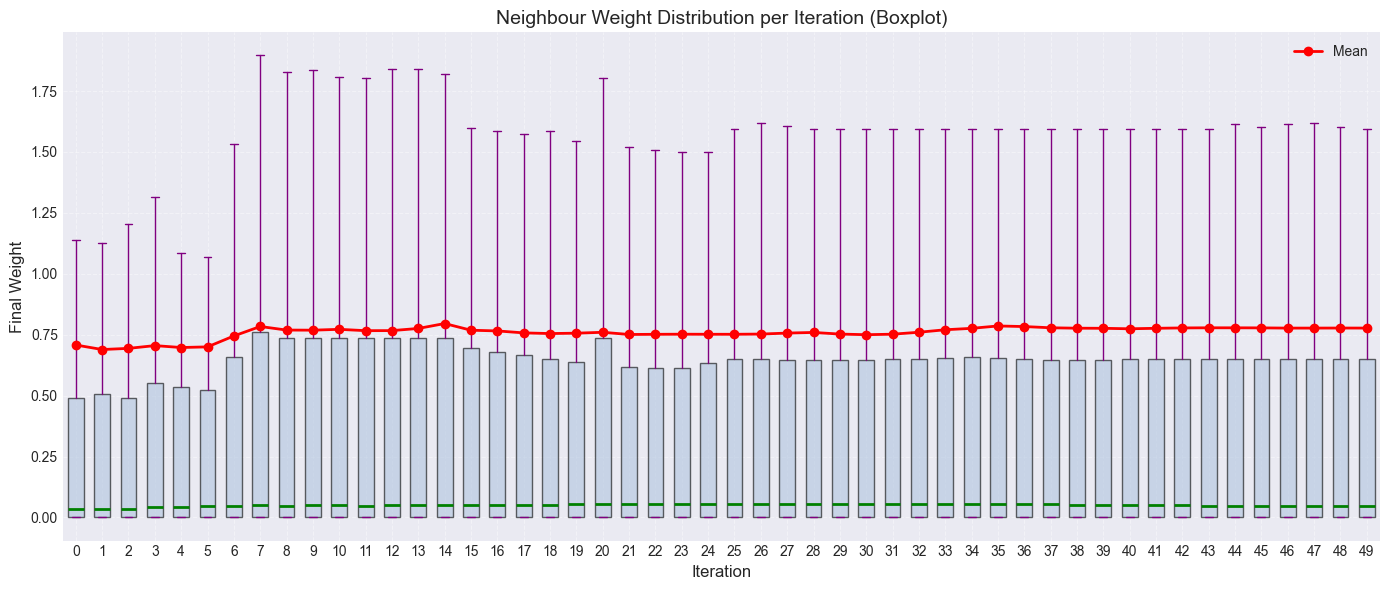

In [14]:
# Boxplot for weights by iteration (requires the previous cell to have run)
if 'weights_subset' in locals():
    box_data = [weights_subset[weights_subset['iteration'] == iteration]['final_weight'].values
                for iteration in iterations]
    mean_values = [data.mean() if len(data) else 0.0 for data in box_data]
    
    fig, ax = plt.subplots(figsize=(14, 6))
    bp = ax.boxplot(box_data, positions=iterations, widths=0.6, patch_artist=True, showfliers=False)
    
    for patch in bp['boxes']:
        patch.set_facecolor('lightsteelblue')
        patch.set_alpha(0.6)
    for median in bp['medians']:
        median.set_color('green')
        median.set_linewidth(2)
    for whisker in bp['whiskers']:
        whisker.set_color('purple')
    for cap in bp['caps']:
        cap.set_color('purple')
    
    ax.plot(iterations, mean_values, color='red', marker='o', linewidth=2, label='Mean')
    
    ax.set_xlabel('Iteration', fontsize=12)
    ax.set_ylabel('Final Weight', fontsize=12)
    ax.set_title('Neighbour Weight Distribution per Iteration (Boxplot)', fontsize=14)
    ax.grid(True, linestyle='--', alpha=0.4)
    ax.legend()
    plt.tight_layout()
    plt.show()
else:
    print("Please run the weight-log loading cell above first.")


In [3]:
from datetime import datetime
datetime.now().second

53

In [ ]:
df = pd.read_csv("/Users/mimuw2022/Documents/GitHub/Social_Tipping_Point/simulation/montecarlosim/data/preprocessedconsumptions4_ICM.csv")

,count,mean,std,min,max
cluster_label,,,,,
durable,54,0.8448,1.6481,0.0,7.3608
non_durable,86,0.2931,0.7184,0.0,5.0000
services,62,0.3735,1.0075,0.0,5.0146


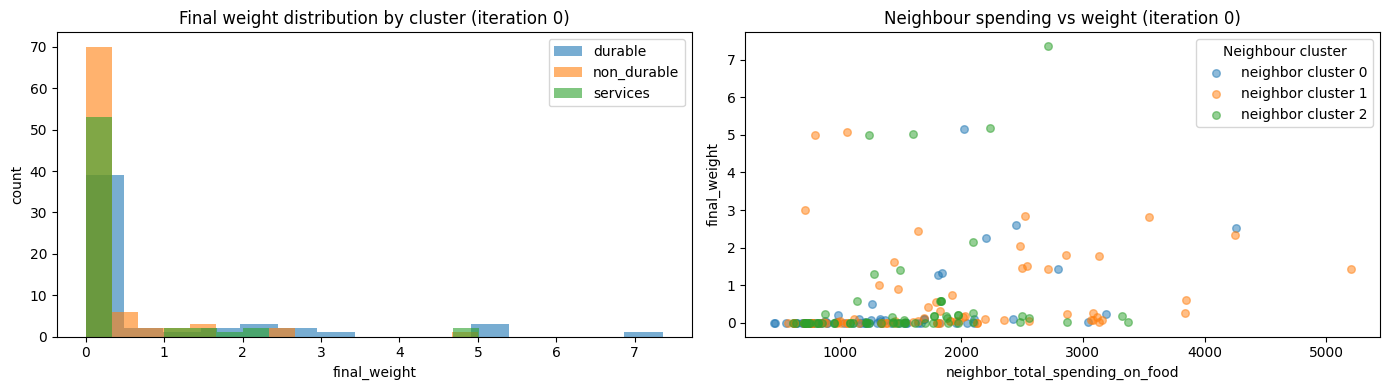

individual_consumption_rate         individual_dur_spend_r  \
                                     mean     std                   mean   
cluster_label                                                              
durable                            0.5553  0.2341                 0.0682   
non_durable                        0.7551  0.0323                 0.0794   
services                           0.7464  0.2171                 0.3284   

                      individual_ndur_spend_r         individual_serv_spend_r  \
                  std                    mean     std                    mean   
cluster_label                                                                   
durable        0.0455                  0.3825  0.0717                  0.1901   
non_durable    0.0819                  0.1803  0.0736                  0.4953   
services       0.0749                  0.1832  0.0451                  0.1944   

                      neighbor_consumption_rate         neighbor_dur_spend_r  \
                  std                      mean     std                 mean   
cluster_label                                                                  
durable        0.0888                    0.8060  0.3979               0.1495   
non_durable    0.0753                    1.1211  1.2613               0.2235   
services       0.0911                    0.9454  0.4363               0.2148   

                      neighbor_ndur_spend_r         neighbor_serv_spend_r  \
                  std                  mean     std                  mean   
cluster_label                                                               
durable        0.1201                0.2879  0.1233                0.2553   
non_durable    0.1651                0.2312  0.1089                0.2914   
services       0.1446                0.2379  0.0787                0.2981   

                       
                  std  
cluster_label          
durable        0.1239  
non_durable    0.1338  
services       0.1330

Observation: iteration-0 weights are heavily shaped by neighbour spending levels. Consider stressing policy levers that differentiate clusters by those neighbour metrics.


In [1]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

# Load the Excel summary produced by analyze_weight_logs.py
summary_path = Path("/Users/mimuw2022/Documents/GitHub/Social_Tipping_Point/simulation/montecarlosim/cluster_logs_20251112_185956_summary.xlsx")
if not summary_path.exists():
    raise FileNotFoundError(f"Summary workbook not found at {summary_path!s}. Run analyze_weight_logs.py first.")

all_sheets = pd.read_excel(summary_path, sheet_name=None)
if not all_sheets:
    raise ValueError("No sheets found in the summary workbook.")

# Combine sheets into one DataFrame while keeping the cluster label
records = []
for label, df_sheet in all_sheets.items():
    df = df_sheet.copy()
    df["cluster_label"] = label
    records.append(df)
weight_df = pd.concat(records, ignore_index=True)

# Focus on the earliest iteration where weights are first applied
weight_df = weight_df[weight_df["iteration"] == 0].copy()
if weight_df.empty:
    raise ValueError("No rows found for iteration 0. Verify the summary workbook contents.")

# Basic descriptive stats to spot which clusters contribute most weight variation
summary_stats = (
    weight_df.groupby("cluster_label")["final_weight"]
    .agg(["count", "mean", "std", "min", "max"])
    .round(4)
)
display(summary_stats)

# Explore the mix of spending vs red-meat components driving the final weight (iteration 0 only)
weight_df["weight_delta"] = (
    weight_df["weight_component_spending"] - weight_df["weight_component_redmeat"]
)

fig, axes = plt.subplots(1, 2, figsize=(14, 4))
for label, group in weight_df.groupby("cluster_label"):
    axes[0].hist(group["final_weight"], bins=15, alpha=0.6, label=label)
axes[0].set_title("Final weight distribution by cluster (iteration 0)")
axes[0].set_xlabel("final_weight")
axes[0].set_ylabel("count")
axes[0].legend()

# Incorporate neighbour information directly: final weight vs neighbour spending
for label, group in weight_df.groupby("neighbor_cluster_id"):
    axes[1].scatter(
        group["neighbor_total_spending_on_food"],
        group["final_weight"],
        s=30,
        alpha=0.5,
        label=f"neighbor cluster {label}",
    )
axes[1].set_title("Neighbour spending vs weight (iteration 0)")
axes[1].set_xlabel("neighbor_total_spending_on_food")
axes[1].set_ylabel("final_weight")
axes[1].legend(title="Neighbour cluster")

plt.tight_layout()
plt.show()

# Quick look at household + neighbour attributes to spot policy levers
attribute_cols = [
    "individual_consumption_rate",
    "individual_dur_spend_r",
    "individual_ndur_spend_r",
    "individual_serv_spend_r",
    "neighbor_consumption_rate",
    "neighbor_dur_spend_r",
    "neighbor_ndur_spend_r",
    "neighbor_serv_spend_r",
]
attr_summary = (
    weight_df.groupby("cluster_label")[attribute_cols]
    .agg(["mean", "std"])
    .round(4)
)
display(attr_summary)

print(
    "Observation: iteration-0 weights are heavily shaped by neighbour spending levels."
    " Consider stressing policy levers that differentiate clusters by those neighbour metrics."
)


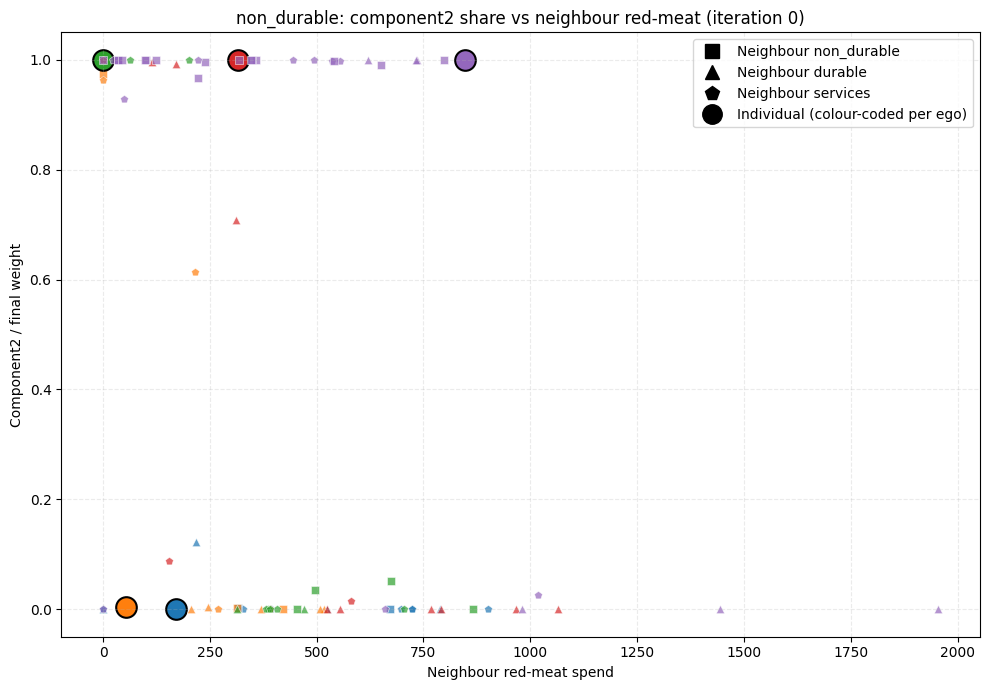

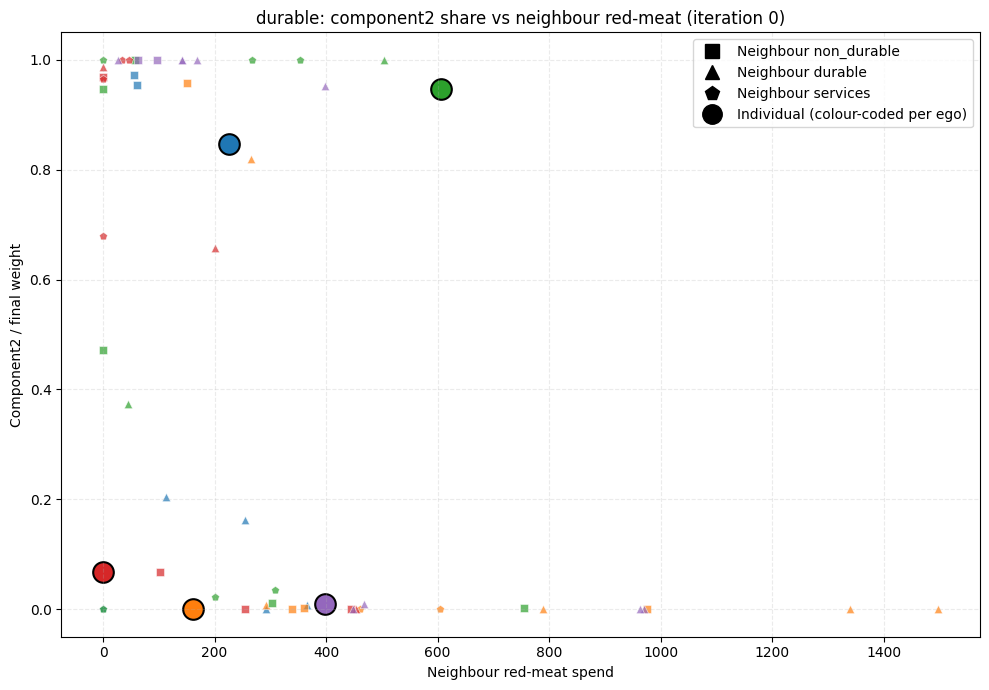

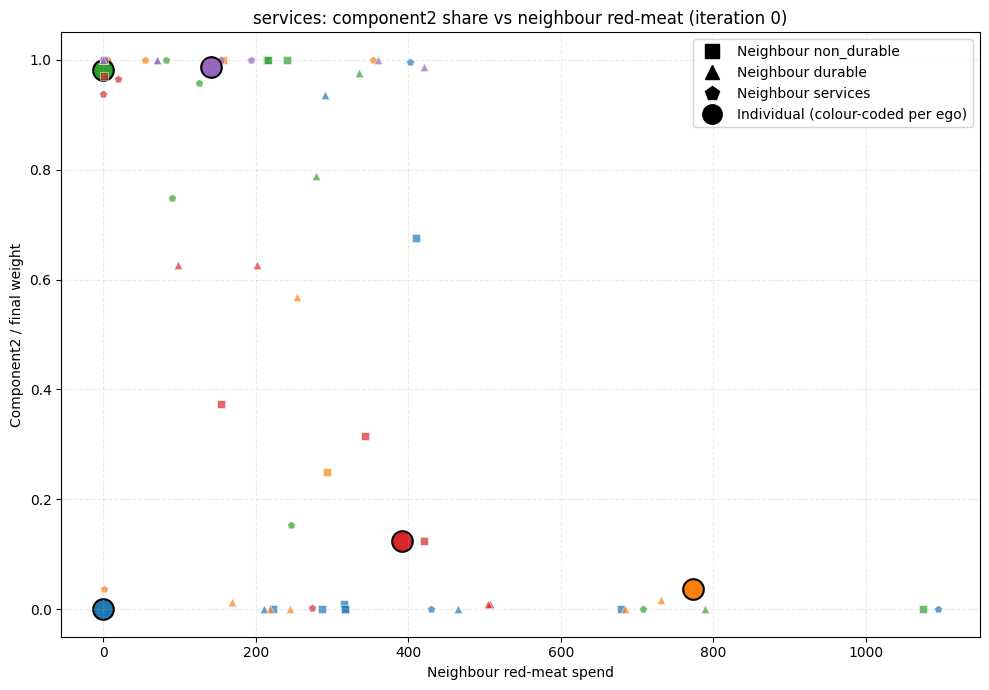

In [1]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import itertools

# Reload summary (iteration 0 already filtered earlier)
if 'weight_df' not in locals():
    summary_path = Path("/Users/mimuw2022/Documents/GitHub/Social_Tipping_Point/simulation/montecarlosim/cluster_logs_20251112_185956_summary.xlsx")
    all_sheets = pd.read_excel(summary_path, sheet_name=None)
    records = []
    for label, df_sheet in all_sheets.items():
        df = df_sheet.copy()
        df["cluster_label"] = label
        records.append(df)
    weight_df = pd.concat(records, ignore_index=True)
    weight_df = weight_df[weight_df["iteration"] == 0].copy()

# Ratio = red-meat component (component2) / total weight
ratio = weight_df["weight_component_redmeat"] / weight_df["final_weight"].replace({0: pd.NA})
weight_df["redmeat_ratio"] = ratio.fillna(0)

# Map neighbour cluster ids to labels to pick markers
cluster_label_map = {0: "non_durable", 1: "durable", 2: "services"}
marker_map = {
    "non_durable": "s",  # square
    "durable": "^",      # triangle
    "services": "p",     # pentagon
}

# Colour palette for individuals
palette = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple", "tab:brown", "tab:pink", "tab:olive", "tab:cyan"]

for cluster_label in weight_df['cluster_label'].unique():
    subset = weight_df[weight_df['cluster_label'] == cluster_label]
    colour_cycle = itertools.cycle(palette)

    fig, ax = plt.subplots(figsize=(10, 7))
    for individual_id, rows in subset.groupby('individual'):
        colour = next(colour_cycle)
        for _, row in rows.iterrows():
            neighbour_label = cluster_label_map.get(row['neighbor_cluster_id'], 'other')
            marker = marker_map.get(neighbour_label, 'o')
            ax.scatter(
                row['neighbor_redmeat'],
                row['redmeat_ratio'],
                marker=marker,
                color=colour,
                alpha=0.7,
                edgecolor='white',
                linewidth=0.5,
            )
        ax.scatter(
            rows['individual_redmeat'].iloc[0],
            rows['redmeat_ratio'].iloc[0],
            marker='o',
            color=colour,
            s=220,
            edgecolor='black',
            linewidth=1.5,
        )

    ax.set_title(f"{cluster_label}: component2 share vs neighbour red-meat (iteration 0)")
    ax.set_xlabel('Neighbour red-meat spend')
    ax.set_ylabel('Component2 / final weight')
    ax.grid(True, linestyle='--', alpha=0.25)

    legend_handles = [
        mlines.Line2D([], [], color='black', marker=marker, linestyle='None', markersize=10, label=f'Neighbour {label}')
        for label, marker in marker_map.items()
    ]
    legend_handles.append(
        mlines.Line2D([], [], color='black', marker='o', linestyle='None', markersize=14, markeredgecolor='black', linewidth=0, label='Individual (colour-coded per ego)')
    )
    ax.legend(handles=legend_handles, loc='upper right')

    plt.tight_layout()
    plt.show()


In [2]:
import pandas as pd
df = pd.read_csv("/Users/mimuw2022/Documents/GitHub/Social_Tipping_Point/simulation/montecarlosim/data/preprocessedconsumptions4_ICM.csv")

In [3]:
df["kmeans_cluster"].unique()

array([1, 0, 2])

In [50]:
df0 = pd.read_excel("/Users/mimuw2022/Documents/GitHub/Social_Tipping_Point/simulation/montecarlosim/MC_runs_20251116_210749/run_00/MC_cluster_run_00_20251116_210749.xlsx")
df1 = pd.read_excel("/Users/mimuw2022/Documents/GitHub/Social_Tipping_Point/simulation/montecarlosim/MC_runs_20251116_210749/run_01/MC_cluster_run_01_20251116_210749.xlsx")
df2 = pd.read_excel("/Users/mimuw2022/Documents/GitHub/Social_Tipping_Point/simulation/montecarlosim/MC_runs_20251116_210749/run_02/MC_cluster_run_02_20251116_210749.xlsx")

In [51]:
df3 = pd.concat([df0 , df1, df2])

In [52]:
[x for x in list(df3.columns) if len(x) < 15]

['alpha_0',
 'alpha',
 'beta',
 'sit',
 'x',
 'cluster_factor',
 'lancet_pct',
 'n_lancet_nodes',
 'run',
 'combo_index',
 'cluster number',
 'random']

In [53]:
df3[['lancet_pct',
 'cluster_factor',
 'run',
 'cluster number',
 'net_final_denormalized_total_emission_from_food_total']]

,lancet_pct,cluster_factor,run,cluster number,net_final_denormalized_total_emission_from_food_total
0,0.000,0,0,0,2.431980e+06
1,0.002,0,0,0,2.414749e+06
2,0.020,0,0,0,2.408995e+06
3,0.060,0,0,0,2.383917e+06
4,0.150,0,0,0,2.308003e+06
...,...,...,...,...,...
43,0.060,1,2,2,2.317585e+06
44,0.150,1,2,2,2.261030e+06
45,0.290,1,2,2,2.237766e+06
46,0.500,1,2,2,2.203427e+06


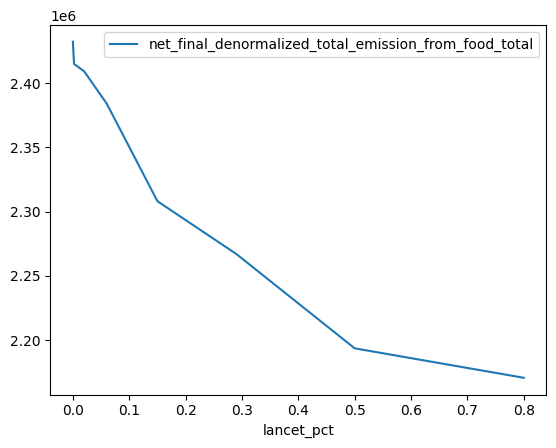

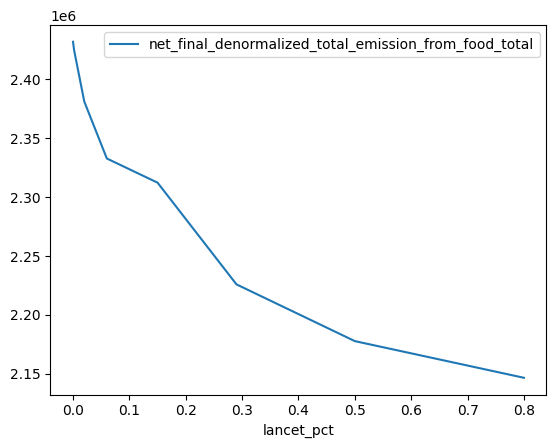

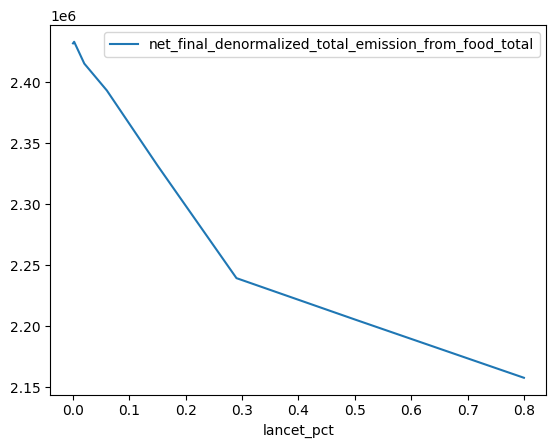

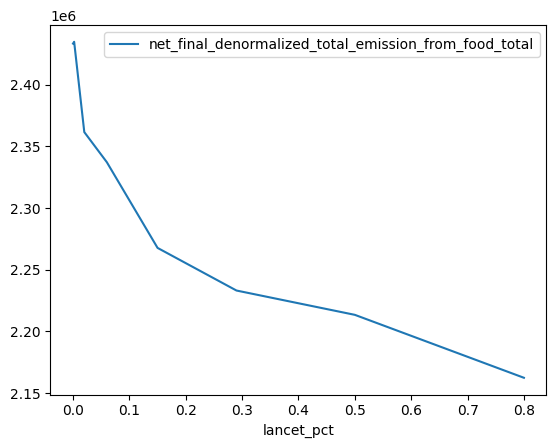

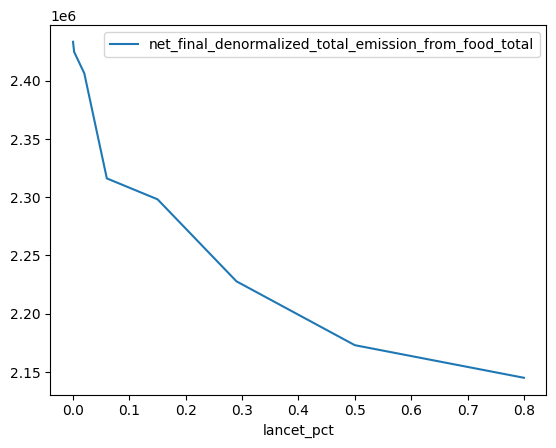

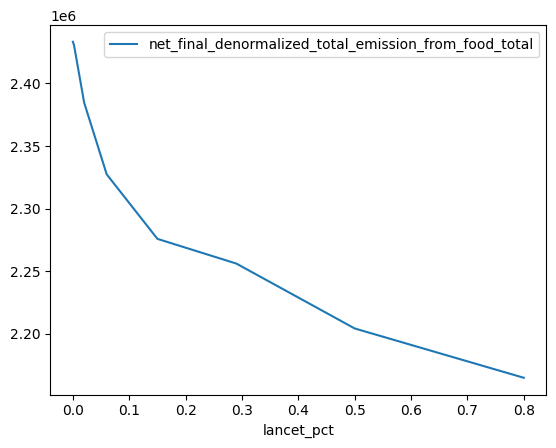

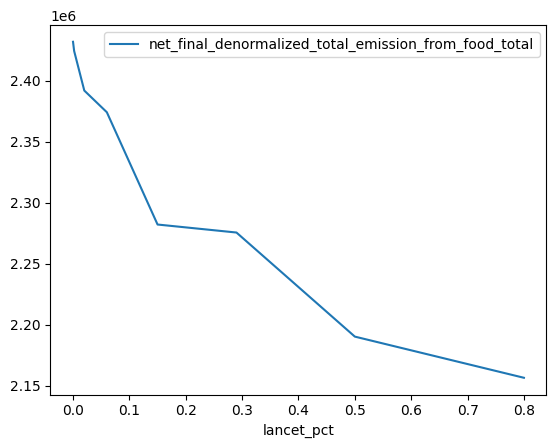

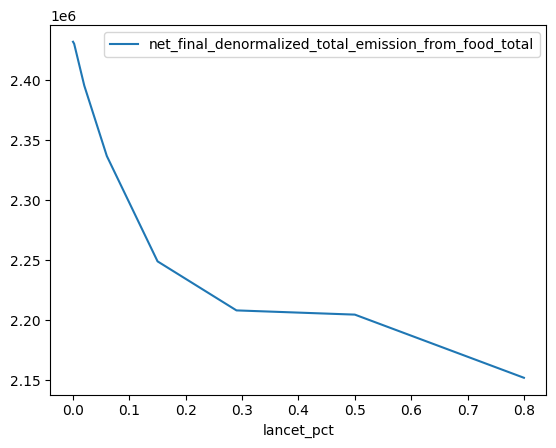

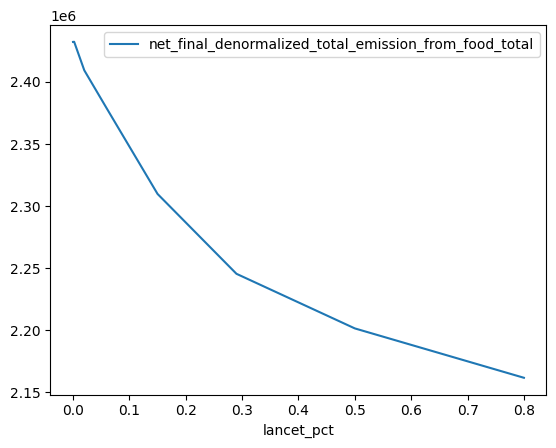

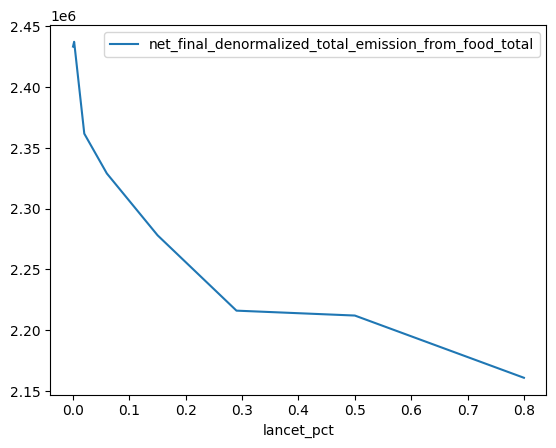

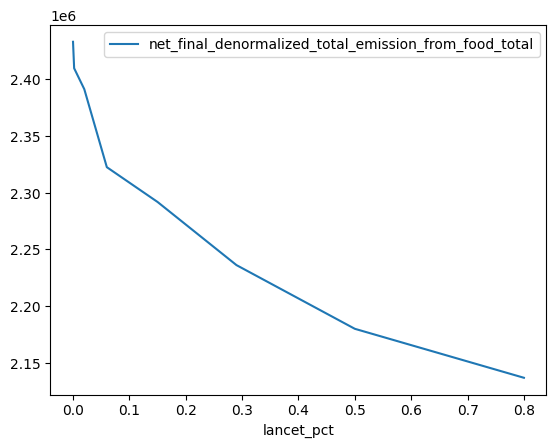

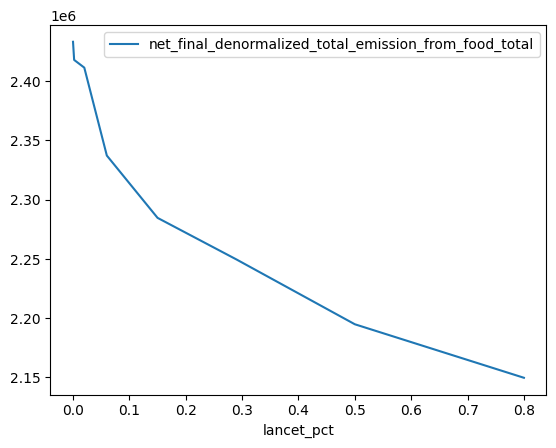

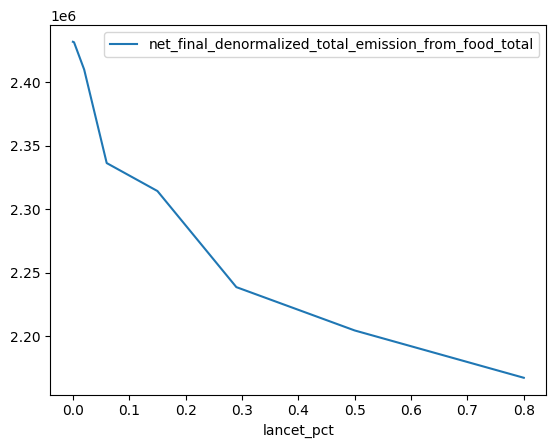

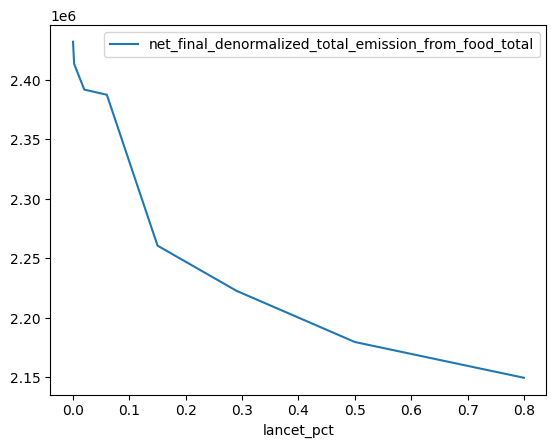

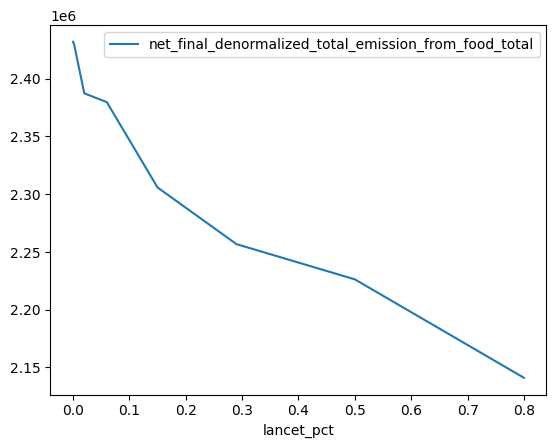

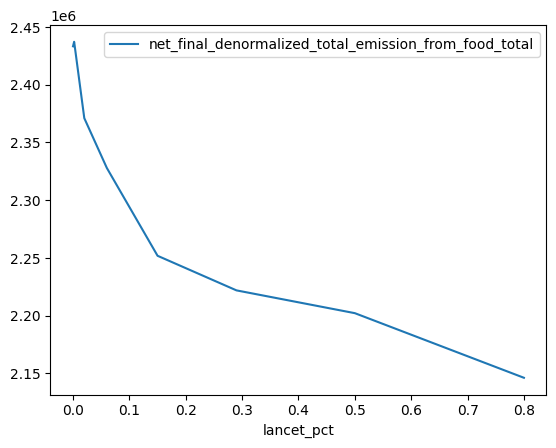

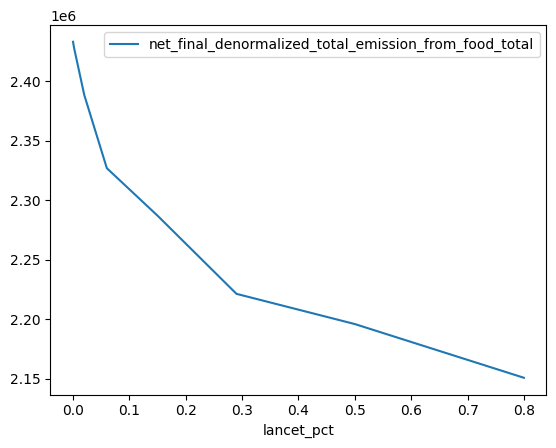

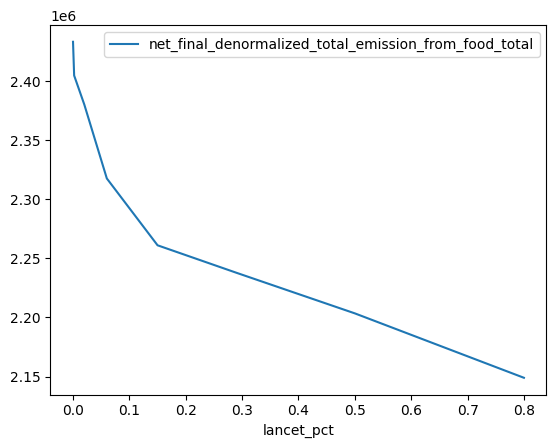

In [54]:
df3.groupby(["run", "cluster_factor", "cluster number"]).plot("lancet_pct", "net_final_denormalized_total_emission_from_food_total")
plt.show()

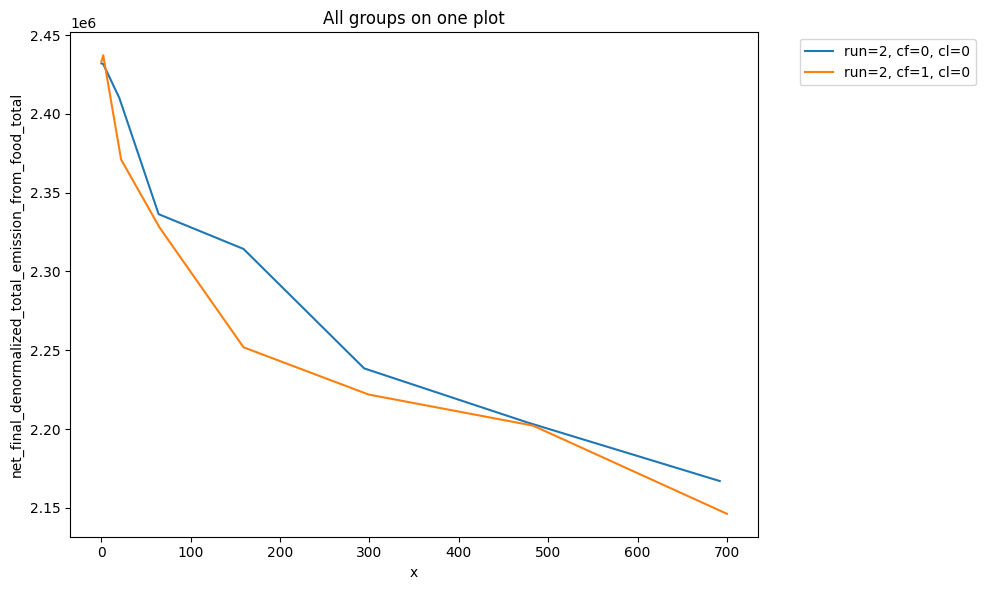

In [48]:
import matplotlib.pyplot as plt

df4 = df2[df2["cluster number"] == 0]

fig, ax = plt.subplots(figsize=(10,6))

for (run, cluster_factor, cluster_number), group in df4.groupby(
        ["run", "cluster_factor", "cluster number"]):
    
    ax.plot(
        group["x"],
        group["net_final_denormalized_total_emission_from_food_total"],
        label=f"run={run}, cf={cluster_factor}, cl={cluster_number}"
    )

ax.set_xlabel("x")
ax.set_ylabel("net_final_denormalized_total_emission_from_food_total")
ax.set_title("All groups on one plot")
ax.legend(bbox_to_anchor=(1.05,1), loc="upper left")  # Move legend outside
plt.tight_layout()
plt.show()

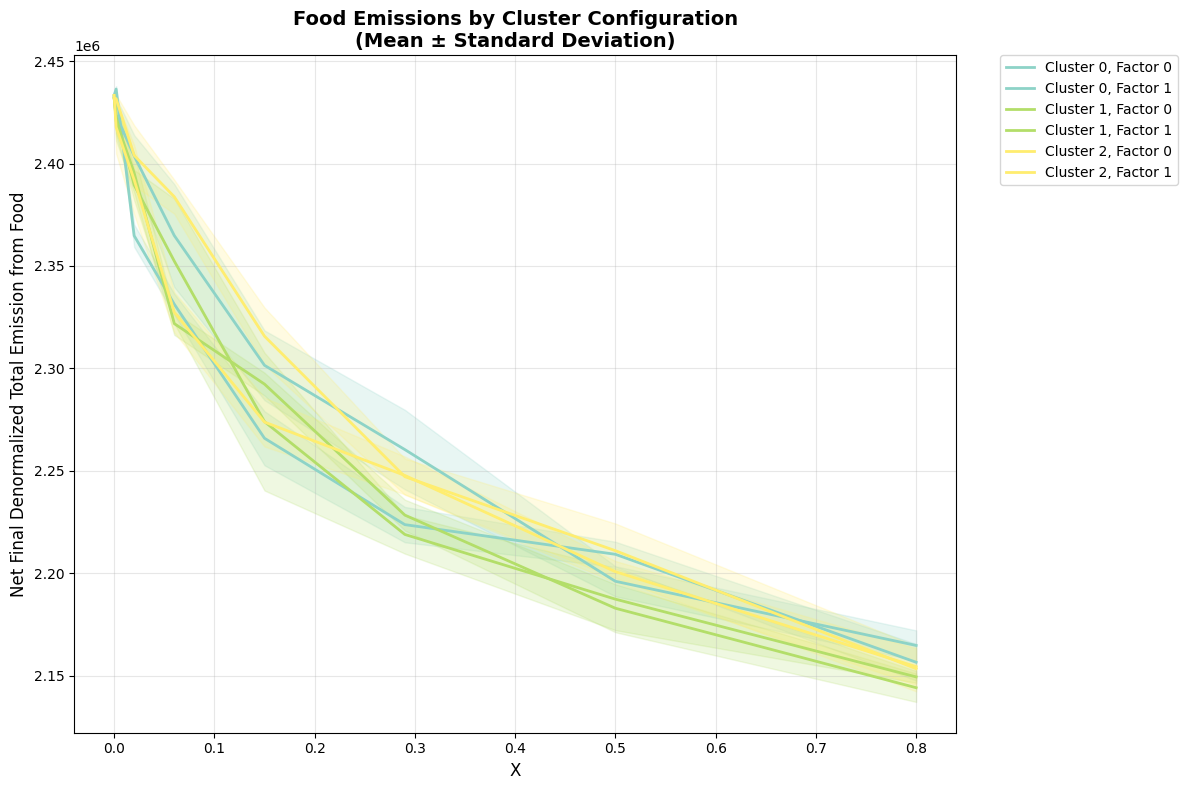

In [57]:
import matplotlib.pyplot as plt
import numpy as np


# Calculate mean and standard deviation for each combination
summary = df3.groupby(["cluster_factor", "cluster number", "lancet_pct"])["net_final_denormalized_total_emission_from_food_total"].agg(['mean', 'std']).reset_index()

# Create the plot
plt.figure(figsize=(12, 8))

# Define colors for different cluster numbers
colors = plt.cm.Set3(np.linspace(0, 1, len(summary['cluster number'].unique())))

# Define line styles for different cluster factors
line_styles = {'low': '-', 'medium': '--', 'high': '-.', 'very_high': ':'}
# Adjust the keys based on your actual cluster_factor values

for i, cluster_num in enumerate(sorted(summary['cluster number'].unique())):
    for cluster_factor in sorted(summary['cluster_factor'].unique()):
        # Filter data for this combination
        mask = (summary['cluster number'] == cluster_num) & (summary['cluster_factor'] == cluster_factor)
        subset = summary[mask]
        
        if len(subset) > 0:
            # Get color and line style
            color = colors[i]
            line_style = line_styles.get(cluster_factor, '-')
            
            # Plot mean line
            plt.plot(subset['lancet_pct'], subset['mean'], 
                    color=color, linestyle=line_style, linewidth=2,
                    label=f'Cluster {cluster_num}, Factor {cluster_factor}')
            
            # Plot confidence region (mean ± std)
            plt.fill_between(subset['lancet_pct'], 
                           subset['mean'] - subset['std'],
                           subset['mean'] + subset['std'],
                           color=color, alpha=0.2)

# Add labels and title
plt.xlabel('X', fontsize=12)
plt.ylabel('Net Final Denormalized Total Emission from Food', fontsize=12)
plt.title('Food Emissions by Cluster Configuration\n(Mean ± Standard Deviation)', fontsize=14, fontweight='bold')

# Improve legend
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., fontsize=10)

# Add grid for better readability
plt.grid(True, alpha=0.3)

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

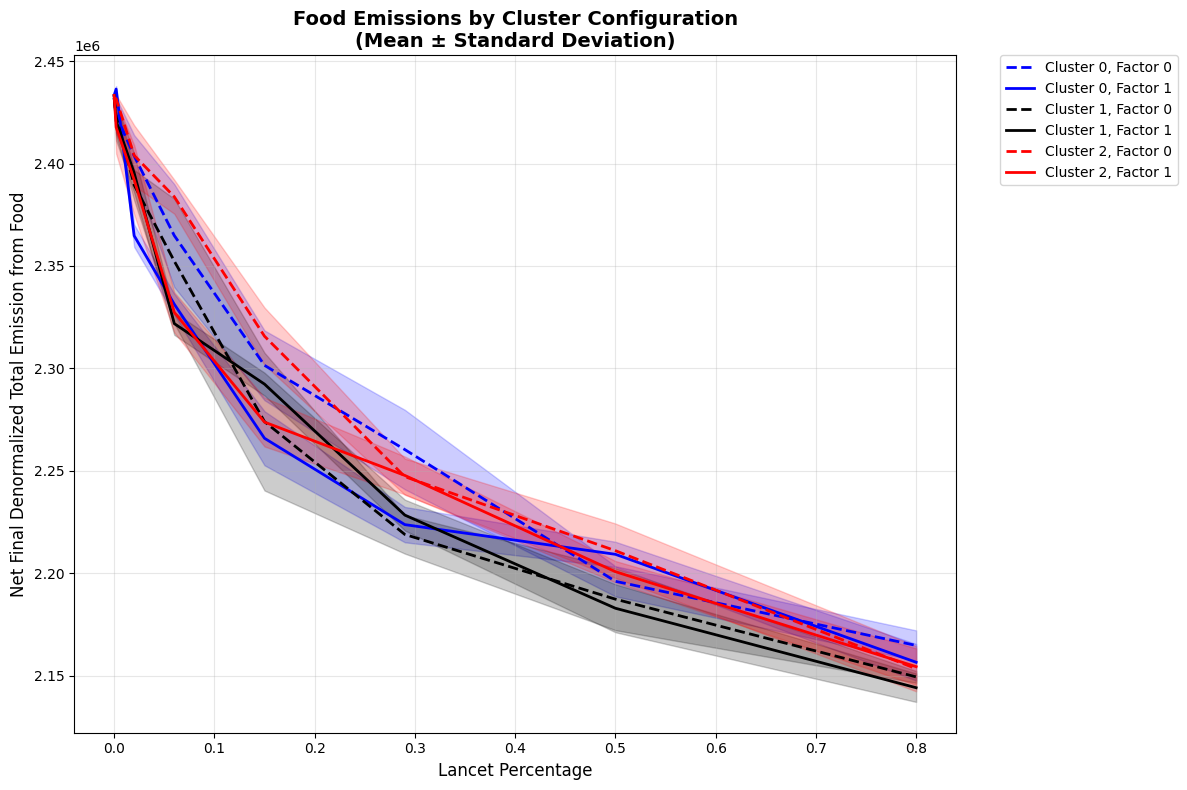

In [60]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate mean and standard deviation for each combination
summary = df3.groupby(["cluster_factor", "cluster number", "lancet_pct"])["net_final_denormalized_total_emission_from_food_total"].agg(['mean', 'std']).reset_index()

# Create the plot
plt.figure(figsize=(12, 8))

# Define specific colors for cluster numbers 0, 1, 2
colors = {0: 'blue', 1: 'black', 2: 'red'}

# Define line styles for cluster factors 0 and 1
line_styles = {0: '--', 1: '-'}  # cluster_factor 0: dashed, cluster_factor 1: solid

for cluster_num in sorted(summary['cluster number'].unique()):
    for cluster_factor in sorted(summary['cluster_factor'].unique()):
        # Filter data for this combination
        mask = (summary['cluster number'] == cluster_num) & (summary['cluster_factor'] == cluster_factor)
        subset = summary[mask]
        
        if len(subset) > 0:
            # Get color and line style
            color = colors[cluster_num]
            line_style = line_styles[cluster_factor]
            
            # Plot mean line
            plt.plot(subset['lancet_pct'], subset['mean'], 
                    color=color, linestyle=line_style, linewidth=2,
                    label=f'Cluster {cluster_num}, Factor {cluster_factor}')
            
            # Plot confidence region (mean ± std)
            plt.fill_between(subset['lancet_pct'], 
                           subset['mean'] - subset['std'],
                           subset['mean'] + subset['std'],
                           color=color, alpha=0.2)

# Add labels and title
plt.xlabel('Lancet Percentage', fontsize=12)
plt.ylabel('Net Final Denormalized Total Emission from Food', fontsize=12)
plt.title('Food Emissions by Cluster Configuration\n(Mean ± Standard Deviation)', fontsize=14, fontweight='bold')

# Improve legend
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., fontsize=10)

# Add grid for better readability
plt.grid(True, alpha=0.3)

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

In [ ]:
/Users/mimuw2022/Downloads/MC_runs_20251119_191329/run_00/MC_cluster_run_00_20251119_191329.xlsx

In [ ]:
/Users/mimuw2022/Downloads/MC_runs_20251119_191329/run_00/MC_cluster_run_00_20251119_191329.xlsx

In [ ]:
MC_runs_20251121_214907

In [ ]:
MC_runs_20251121_214907

In [ ]:
MC_runs_20251128_221513

In [15]:
import pandas as pd

df = pd.DataFrame()

for i in range(1):
    loc = f"/Users/mimuw2022/Downloads/MC_runs_20251130_230812/run_0{i}/MC_cluster_run_0{i}_20251130_230812.xlsx"
    df_new = pd.read_excel(loc)
    df = pd.concat([df, df_new])

#df = pd.read_excel("/Users/mimuw2022/Documents/GitHub/Social_Tipping_Point/simulation/montecarlosim/MC_runs_20251130_224112/run_00/MC_cluster_run_00_20251130_224112.xlsx")

In [16]:
df

,alpha_0,alpha,beta,sit,x,dynamic_initial_total_emission_from_food_mean,dynamic_initial_total_emission_from_food_var,dynamic_initial_total_emission_from_food_total,dynamic_initial_denormalized_total_emission_from_food_mean,dynamic_initial_denormalized_total_emission_from_food_var,...,afterdiet_static_Pork_aggregated_protein_share_total,afterdiet_static_Lamb_and_goat_aggregated_protein_share_mean,afterdiet_static_Lamb_and_goat_aggregated_protein_share_var,afterdiet_static_Lamb_and_goat_aggregated_protein_share_total,afterdiet_static_Poultry_aggregated_protein_share_mean,afterdiet_static_Poultry_aggregated_protein_share_var,afterdiet_static_Poultry_aggregated_protein_share_total,cluster number,random,net_final_denormalized_total_emission_from_food_total
0,0.5,0.3,0.2,0.005,0,1610.234778,1.487176e+06,1.313307e+07,3050.121633,7.047166e+06,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,1,True,2.490390e+07
1,0.5,0.3,0.2,0.005,22,1609.304341,1.477768e+06,1.309008e+07,3045.871664,6.945390e+06,...,0.165072,0.001367,0.000005,0.030082,0.030818,1.134923e-34,0.678002,1,True,2.494429e+07
2,0.5,0.3,0.2,0.005,218,1615.430349,1.501775e+06,1.282329e+07,3059.009200,7.109280e+06,...,1.585763,0.002231,0.000009,0.486278,0.030818,4.837013e-35,6.718385,1,True,2.497854e+07
3,0.5,0.3,0.2,0.005,646,1611.531478,1.489279e+06,1.210260e+07,3065.626066,7.161015e+06,...,4.532812,0.002271,0.000008,1.466963,0.030818,1.085015e-34,19.908608,1,True,2.476934e+07
4,0.5,0.3,0.2,0.005,1574,1622.606971,1.516006e+06,1.068000e+07,3091.832741,7.171440e+06,...,11.211042,0.002225,0.000007,3.502080,0.030818,1.084024e-34,48.507970,1,True,2.453817e+07
5,0.5,0.3,0.2,0.005,2918,1658.196390,1.550082e+06,8.685633e+06,3160.197409,7.291866e+06,...,20.909325,0.002147,0.000007,6.263730,0.030818,4.816475e-35,89.927736,1,True,2.410097e+07
6,0.5,0.3,0.2,0.005,4765,1680.766173,1.655712e+06,5.699478e+06,3262.279055,8.208158e+06,...,33.989476,0.002120,0.000007,10.102331,0.030818,4.815836e-35,146.849097,1,True,2.319500e+07
7,0.5,0.3,0.2,0.005,6967,1796.458763,1.936916e+06,2.135989e+06,3542.144244,1.052469e+07,...,50.590149,0.002017,0.000007,14.049411,0.030818,4.815516e-35,214.710946,1,True,2.226471e+07
8,0.5,0.3,0.2,0.005,0,1610.234778,1.487176e+06,1.313307e+07,3050.121633,7.047166e+06,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,2,True,2.490390e+07
9,0.5,0.3,0.2,0.005,22,1610.698325,1.489476e+06,1.310142e+07,3051.043205,7.058934e+06,...,0.205386,0.001658,0.000006,0.036486,0.030818,1.134923e-34,0.678002,2,True,2.491354e+07


In [17]:
df["Average emission from food"] = df["net_final_denormalized_total_emission_from_food_total"]/8156.3

In [21]:
legend_map = {
    "Cluster 1": "Mid-quantile 1",
    "Cluster 2": "Mid-quantile 2",
    "Cluster 3": "Mid-quantile 3",
    "Factor 0": "Factor 0",
    "Factor 1": "Factor 1"
}

def convert_legend_label(label):
    """
    Convert legend labels using legend_map.
    Input example: 'Cluster 1, Factor 0'
    Output example: 'Mid-quantile 1, Factor 0'
    """
    parts = [p.strip() for p in label.split(",")]
    
    converted_parts = []
    for p in parts:
        # find matching dictionary key
        for key in legend_map:
            if p.startswith(key):
                converted_parts.append(legend_map[key])
                break
        else:
            # if no mapping, keep original
            converted_parts.append(p)

    return ", ".join(converted_parts)

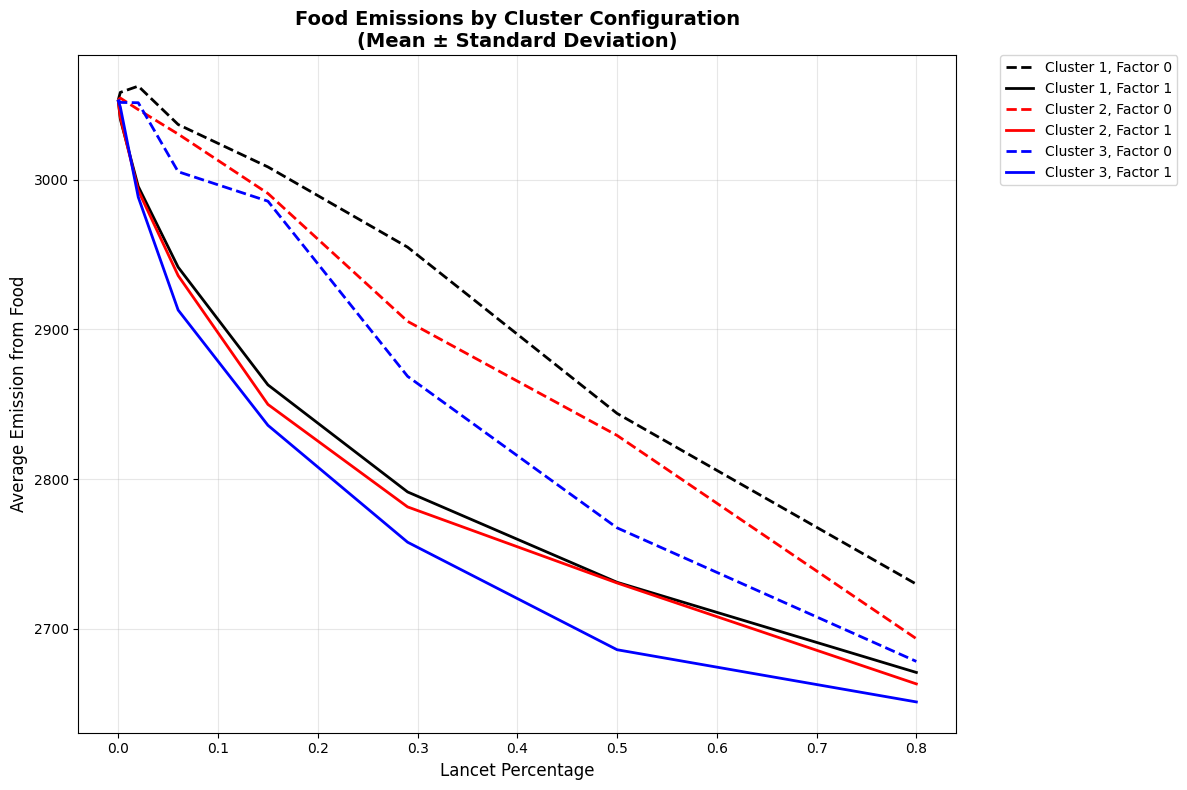

In [19]:
import matplotlib.pyplot as plt
import numpy as np

df1 = df[(df["lancet_pct"] > 0.05) & (df["lancet_pct"] < 0.3)]

# Calculate mean and standard deviation for each combination
summary = df.groupby(["cluster_factor", "cluster number", "lancet_pct"])["Average emission from food"].agg(['mean', 'std']).reset_index()

# Create the plot
plt.figure(figsize=(12, 8))

# Define specific colors for cluster numbers 0, 1, 2
colors = {3: 'blue', 1: 'black', 2: 'red'}

# Define line styles for cluster factors 0 and 1
line_styles = {0: '--', 1: '-'}  # cluster_factor 0: dashed, cluster_factor 1: solid

for cluster_num in sorted(summary['cluster number'].unique()):
    for cluster_factor in sorted(summary['cluster_factor'].unique()):
        # Filter data for this combination
        mask = (summary['cluster number'] == cluster_num) & (summary['cluster_factor'] == cluster_factor)
        subset = summary[mask]
        
        if len(subset) > 0:
            # Get color and line style
            color = colors[cluster_num]
            line_style = line_styles[cluster_factor]
            
            # Plot mean line
            plt.plot(subset['lancet_pct'], subset['mean'], 
                    color=color, linestyle=line_style, linewidth=2,
                    label=f'Cluster {cluster_num}, Factor {cluster_factor}')
            
            # Plot confidence region (mean ± std)
            plt.fill_between(subset['lancet_pct'], 
                           subset['mean'] - subset['std'],
                           subset['mean'] + subset['std'],
                           color=color, alpha=0.2)

# Add labels and title
plt.xlabel('Lancet Percentage', fontsize=12)
plt.ylabel('Average Emission from Food', fontsize=12)
plt.title('Food Emissions by Cluster Configuration\n(Mean ± Standard Deviation)', fontsize=14, fontweight='bold')

handles, labels = ax.get_legend_handles_labels()
new_labels = [convert_legend_label(lbl) for lbl in labels]
ax.legend(handles, new_labels, fontsize=12)

# Improve legend
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., fontsize=10)

# Add grid for better readability
plt.grid(True, alpha=0.3)

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

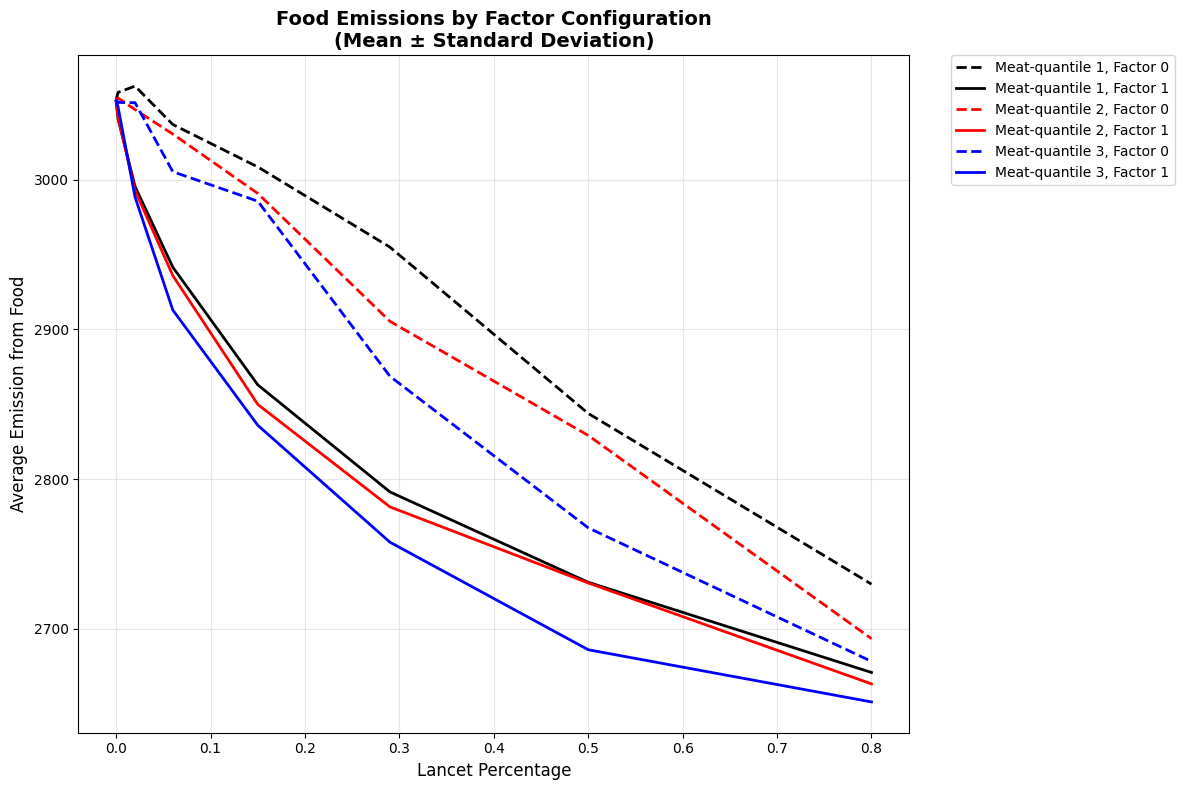

In [23]:
import matplotlib.pyplot as plt
import numpy as np

legend_map = {
    "Cluster 1": "Meat-quantile 1",
    "Cluster 2": "Meat-quantile 2",
    "Cluster 3": "Meat-quantile 3",
    "Factor 0": "Factor 0",
    "Factor 1": "Factor 1"
}

def convert_legend_label(label):
    """
    Convert legend labels using legend_map.
    Input example: 'Cluster 1, Factor 0'
    Output example: 'Mid-quantile 1, Factor 0'
    """
    parts = [p.strip() for p in label.split(",")]
    
    converted_parts = []
    for p in parts:
        for key in legend_map:
            if p.startswith(key):
                converted_parts.append(legend_map[key])
                break
        else:
            converted_parts.append(p)

    return ", ".join(converted_parts)


# ---- plotting code ----

# if you really wanted 0.05<lancet_pct<0.3 then use df1 below,
# otherwise just use df everywhere
df1 = df[(df["lancet_pct"] > 0.05) & (df["lancet_pct"] < 0.3)]

summary = df.groupby(
    ["cluster_factor", "cluster number", "lancet_pct"]
)["Average emission from food"].agg(['mean', 'std']).reset_index()

fig, ax = plt.subplots(figsize=(12, 8))

colors = {3: 'blue', 1: 'black', 2: 'red'}
line_styles = {0: '--', 1: '-'}

for cluster_num in sorted(summary['cluster number'].unique()):
    for cluster_factor in sorted(summary['cluster_factor'].unique()):
        mask = (
            (summary['cluster number'] == cluster_num) &
            (summary['cluster_factor'] == cluster_factor)
        )
        subset = summary[mask]
        
        if len(subset) > 0:
            color = colors[cluster_num]
            line_style = line_styles[cluster_factor]
            
            ax.plot(
                subset['lancet_pct'], subset['mean'],
                color=color, linestyle=line_style, linewidth=2,
                label=f'Cluster {cluster_num}, Factor {cluster_factor}'
            )
            
            ax.fill_between(
                subset['lancet_pct'],
                subset['mean'] - subset['std'],
                subset['mean'] + subset['std'],
                color=color, alpha=0.2
            )

ax.set_xlabel('Lancet Percentage', fontsize=12)
ax.set_ylabel('Average Emission from Food', fontsize=12)
ax.set_title(
    'Food Emissions by Factor Configuration\n(Mean ± Standard Deviation)',
    fontsize=14, fontweight='bold'
)

# get original legend labels and convert them
handles, labels = ax.get_legend_handles_labels()
new_labels = [convert_legend_label(lbl) for lbl in labels]
ax.legend(
    handles, new_labels,
    bbox_to_anchor=(1.05, 1),
    loc='upper left',
    borderaxespad=0.,
    fontsize=10
)

ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [26]:
(65250/0.8)/81563

0.9999938697693808

In [ ]:
81563

In [25]:
df1[['alpha_0',
 'alpha',
 'beta',
 'sit',
 'x',
 'cluster_factor',
 'lancet_pct',
 'n_lancet_nodes',
 'run',
 'combo_index',
 'cluster number',
 'random']]

,alpha_0,alpha,beta,sit,x,cluster_factor,lancet_pct,n_lancet_nodes,run,combo_index,cluster number,random
0,0.5,0.3,0.2,0.005,0,0,0.000,0,0,0,0,True
1,0.5,0.3,0.2,0.005,218,0,0.002,163,0,1,0,True
2,0.5,0.3,0.2,0.005,2178,0,0.020,1631,0,2,0,True
3,0.5,0.3,0.2,0.005,6472,0,0.060,4893,0,3,0,True
4,0.5,0.3,0.2,0.005,15851,0,0.150,12234,0,4,0,True
5,0.5,0.3,0.2,0.005,29289,0,0.290,23653,0,5,0,True
6,0.5,0.3,0.2,0.005,47702,0,0.500,40781,0,6,0,True
7,0.5,0.3,0.2,0.005,69797,0,0.800,65250,0,7,0,True
24,0.5,0.3,0.2,0.005,0,1,0.000,0,0,0,0,True
25,0.5,0.3,0.2,0.005,219,1,0.002,163,0,1,0,True


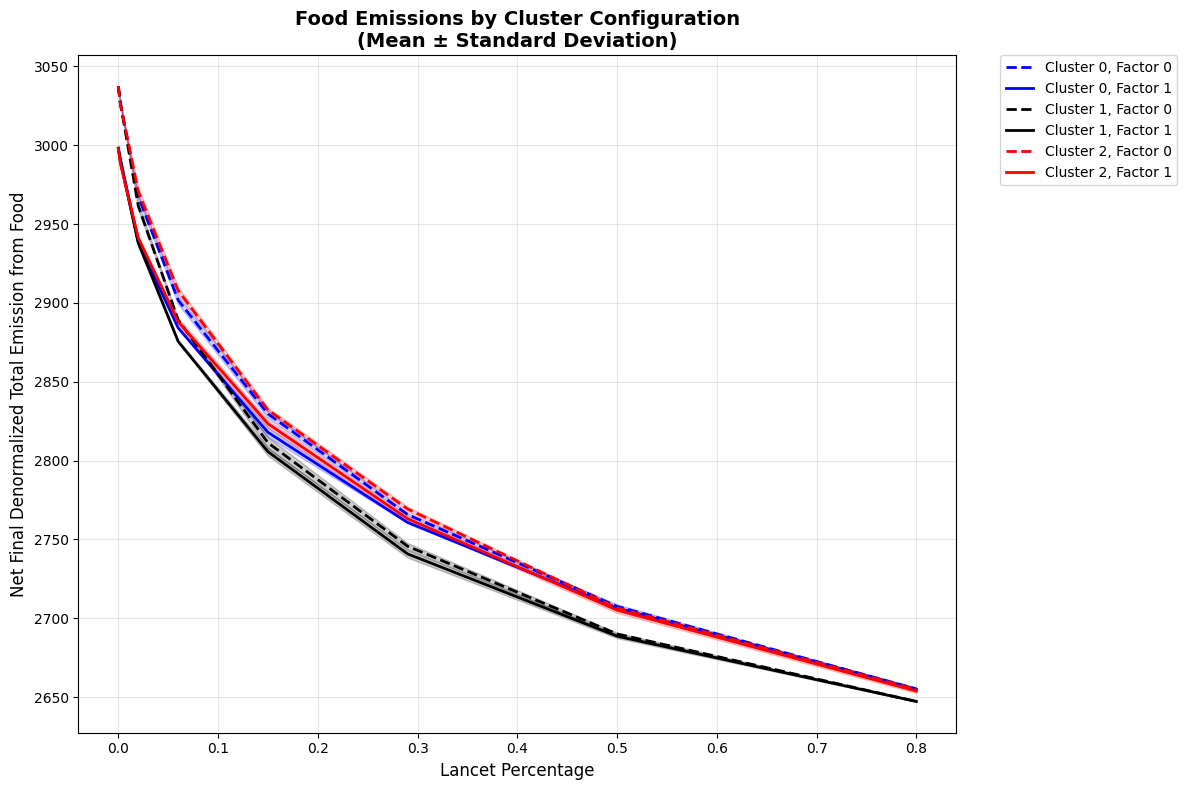

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate mean and standard deviation for each combination
summary = df.groupby(["cluster_factor", "cluster number", "lancet_pct"])["Average emission from food"].agg(['mean', 'std']).reset_index()

# Create the plot
plt.figure(figsize=(12, 8))

# Define specific colors for cluster numbers 0, 1, 2
colors = {0: 'blue', 1: 'black', 2: 'red'}

# Define line styles for cluster factors 0 and 1
line_styles = {0: '--', 1: '-'}  # cluster_factor 0: dashed, cluster_factor 1: solid

for cluster_num in sorted(summary['cluster number'].unique()):
    for cluster_factor in sorted(summary['cluster_factor'].unique()):
        # Filter data for this combination
        mask = (summary['cluster number'] == cluster_num) & (summary['cluster_factor'] == cluster_factor)
        subset = summary[mask]
        
        if len(subset) > 0:
            # Get color and line style
            color = colors[cluster_num]
            line_style = line_styles[cluster_factor]
            
            # Plot mean line
            plt.plot(subset['lancet_pct'], subset['mean'], 
                    color=color, linestyle=line_style, linewidth=2,
                    label=f'Cluster {cluster_num}, Factor {cluster_factor}')
            
            # Plot confidence region (mean ± std)
            plt.fill_between(subset['lancet_pct'], 
                           subset['mean'] - subset['std'],
                           subset['mean'] + subset['std'],
                           color=color, alpha=0.2)

# Add labels and title
plt.xlabel('Lancet Percentage', fontsize=12)
plt.ylabel('Net Final Denormalized Total Emission from Food', fontsize=12)
plt.title('Food Emissions by Cluster Configuration\n(Mean ± Standard Deviation)', fontsize=14, fontweight='bold')

# Improve legend
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., fontsize=10)

# Add grid for better readability
plt.grid(True, alpha=0.3)

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()



# Two-Commodity Update and Preservation of Total Share (Our current model)

## Budget Share Update Table

| | **Good 1** | **Good 2** | **Row sum** |
| :--- | :--- | :--- | :--- |
| **Before update** | $S^{1}(t-1)$ | $S^{2}(t-1)$ | $S^{1}(t-1) + S^{2}(t-1) = 1$ |
| **After update** | $(1-\alpha)S^{1}(t-1) + \alpha\sum_{j\neq 1}\omega_{1j}S^{1}_{j}(t-1)$ | $(1-\alpha)S^{2}(t-1) + \alpha\sum_{j\neq 1}\omega_{1j}S^{2}_{j}(t-1)$ | $(1-\alpha)[S^{1}(t-1) + S^{2}(t-1)] + \alpha\sum_{j\neq 1}\omega_{1j}[S^{1}_{j}(t-1) + S^{2}_{j}(t-1)] = 1$ |

*Table: Agent 1's budget shares before and after update, showing that the row sum remains 1.*

---

## Explanation of the "Row sum" entry for the After-update row:

- **First term**: $[S^{1}(t-1) + S^{2}(t-1)] = 1$ because before the update the two shares exhaust the budget.

- **Second term**: $\sum_{j\neq 1}\omega_{1j}[S^{1}_{j}(t-1) + S^{2}_{j}(t-1)] = 1$ because:
  - For each neighbor $j$, $S^{1}_{j}(t-1) + S^{2}_{j}(t-1) = 1$
  - The weights $\omega_{1j}$ sum to 1: $\sum_{j\neq 1}\omega_{1j} = 1$

- **Final result**: Since $(1-\alpha) + \alpha = 1$, the weighted sum becomes:

  $$
  (1-\alpha) \cdot 1 + \alpha \cdot 1 = 1
  $$

  confirming that the updated shares still sum to 1.



| Model | Mathematics and Dynamics | Interpretation and Convergence |
| :--- | :--- | :--- |
| **Altafini Model** | **Mathematics:** This is a continuous-time version of opinion dynamics (Abelson model) where The rate of change of agent $i$'s opinion, $\dot{x}_i(t)$, is a sum of influences it receives from all other agents $j$: $$\dot{x}_i(t) = \sum_{j=1}^n \|a_{ij}\|(x_j(t)\text{sgn}(a_{ij}) - x_i(t)).$$  To adapt with our constant protein intake amount model normalization needed.| **Interpretation:** Altafini proposes a generalization of the DeGroot model where agents may put negative weights on other’s opinions, thus exhibiting anticonformity or anti-trend behavior. The fundamental difference with other models of anticonformity presented so far is that a given agent may weigh positively some agents while weighing negatively some other ones (recall that in all models we have seen so far, an anticonformist agent reacts negatively to all agents). **Convergence:** possibility of polarization|
| **EPO Model** (Expressed-Private-Opinion Model) | **Mathematics:** This is a discrete-time, synchronous update model that tracks two opinion vectors: $\mathbf{x}(k)$ (private) and $\hat{\mathbf{x}}(k)$ (expressed/public). **Private Opinion Dynamics:** The update mechanism is similar to the Friedkin–Johnsen model, incorporating a susceptibility term ($\lambda_i$) and the initial private opinion ($x_i(0)$): $$x_i(k + 1) = \lambda_i \left( w_{ii}x_i(k) + \sum_{j \neq i} w_{ij} \hat{x}_j(k) \right) + (1 - \lambda_i)x_i(0) \quad \text{}$$ **Expressed Opinion Dynamics:** The public opinion is a weighted average of the agent's current private opinion and the previous average public opinion of the group, where $\varphi_i$ is the agent's **resilience**: $$\hat{x}_i(k) = \varphi_i x_i(k) + (1 - \varphi_i)\hat{x}_{\text{ave}}(k - 1) \quad \text{}$$ | **Interpretation:** The model is inspired by social psychology, showing that individuals may express opinions (public) that differ from their true opinion (private) due to **social norm pressure** (like in the Asch experiment). **Convergence:** A steady state for both $\mathbf{x}$ and $\hat{\mathbf{x}}$ is reached exponentially fast, assuming the influence matrix $W$ is primitive and parameters $\lambda_i, \varphi_i \notin \{0, 1\}$. The steady state depends only on the initial **private opinion** $\mathbf{x}(0)$. **Outcome:** Agents exhibit **more consensus** in their expressed opinions ($\hat{V}(\infty)$ is smaller) than they really feel privately ($V(\infty)$ is larger). The model can capture **strong diversity** (a range of diverse opinion values within a cluster). |
| **Hegselmann–Krause Model** (HK Model) (Bounded confidence model) | **Mathematics:** A continuous opinion model that evolves in **discrete time** steps using **synchronous** updating. It is implicitly based on an underlying **complete network**. **Dynamics (Averaging):** Agent $i$ updates its opinion by averaging the opinions of all "trusted" individuals $j$: $$x_i(k + 1) = \frac{1}{\|I_i(\mathbf{x}(k))\|} \sum_{j \in I_i(\mathbf{x}(k))} x_j(k) \quad \text{}$$ **Trusted Set Rule:** The set $I_i(\mathbf{x})$ consists of agents $j$ whose opinions are within a fixed distance $d$ (the **range of confidence**) of $x_i$: $I_i(\mathbf{x}) = \{j : \|x_j - x_i\| \le d\}$. | **Interpretation:** This model is a seminal example of a **Bounded Confidence model** and operates as a simple model of **homophily**, where agents only interact with those whose opinions are already similar. It can be viewed as a French–DeGroot model with a dynamically changing (time-varying) weight matrix $W$. **Convergence:** Convergence to a steady state $\bar{\mathbf{x}}$ is guaranteed in a **finite number of steps** ($O(n^3)$ steps). **Outcome:** The final state exhibits **clustering** or **segmentation**. Agents cluster into groups where consensus ($\bar{x}_i = \bar{x}_j$) is reached internally, but external clusters are separated by more than the confidence range ($\|\bar{x}_i - \bar{x}_j\| > d$), signifying **distrust**. Two maximal $d$-chains can never merge. |

Threshold linear model

# Protein Consumption Model Derivation

## Definitions

Let $S_i^k(t)$ denote the protein share coming from item $k$ (e.g., rice, bread, beef and veal, poultry, cheese, etc.) for agent $i$ at time $t$.

## Update Equations

From the update equations, we have:

$$
S_i^k(t) = S_i^k(t-1)(1-\alpha_i) + \alpha_i \left( \sum_{j \neq i} \omega_{ij}(t) S_j^k(t-1) \right) + \epsilon \text{ (we may add some randomness here)}
$$

Multiplying both sides by total protein consumption of person $i$ ($tpc$), where $P_i^k(t)$ denotes the protein intake coming from item $k$ for agent $i$ at time $t$:

$$
P_i^k(t) = \left( S_i^k(t-1)(1-\alpha_i) + \alpha_i \left( \sum_{j \neq i} \omega_{ij}(t) S_j^k(t-1) \right) \right) \cdot tpc
$$

Dividing both sides by conversion factor gives quantity of item $k$ bought (where $Q_i^k(t)$ denotes the quantity of item $k$ bought by agent $i$ at time $t$):

$$
Q_i^k(t) = \left( S_i^k(t-1)(1-\alpha_i) + \alpha_i \left( \sum_{j \neq i} \omega_{ij}(t) S_j^k(t-1) \right) \right) \cdot \frac{tpc}{conv(k)}
$$

Now multiplying both sides by price gives spending on item $k$ (where $E_i^k(t)$ denotes the money that agent $i$ spent on item $k$ at time $t$):

$$
E_i^k(t) = \left( S_i^k(t-1)(1-\alpha_i) + \alpha_i \left( \sum_{j \neq i} \omega_{ij}(t) S_j^k(t-1) \right) \right) \cdot \frac{tpc \cdot Price(k,i)}{conv(k)}
$$

After simplifying the right hand side (noting $E_i^k(t-1) = S_i^k(t-1) \cdot \frac{tpc \cdot Price(k,i)}{conv(k)}$):

$$
E_i^k(t) = E_i^k(t-1)(1-\alpha_i) + \alpha_i \left( \sum_{j \neq i} \omega_{ij}(t) S_j^k(t-1) \right) \cdot \frac{tpc \cdot Price(k,i)}{conv(k)}
$$

## Total Expense Derivation

Now summing over all items $k$ to get the total expense:

$$
TE_i(t) = \sum_k E_i^k(t) = TE_i(t-1)(1-\alpha_i) + \alpha_i \sum_k \left( \sum_{j \neq i} \omega_{ij}(t) S_j^k(t-1) \right) \cdot \frac{tpc(i) \cdot Price(k,i)}{conv(k)}
$$

$$
TE_i(t) = TE_i(t-1)(1-\alpha_i) + \alpha_i \sum_k \left( \sum_{j \neq i} \omega_{ij}(t) S_j^k(t-1) \cdot \frac{tpc(i) tpc(j) \cdot Price(k,i)}{conv(k) tpc(j)} \right)
$$

$$
TE_i(t) = TE_i(t-1)(1-\alpha_i) + \alpha_i \sum_k \left( \sum_{j \neq i} \omega_{ij}(t) P_j^k(t-1) \cdot \frac{tpc(i) \cdot Price(k,i)}{conv(k) tpc(j)} \right)
$$

$$
TE_i(t) = TE_i(t-1)(1-\alpha_i) + \alpha_i \sum_k \left( \sum_{j \neq i} \omega_{ij}(t) SP_j^k(t-1) \cdot \frac{tpc(i) \cdot Price(k,i)}{tpc(j) Price(k,j)} \right)
$$

$$
TE_i(t) = TE_i(t-1)(1-\alpha_i) + \alpha_i \sum_k \left( \sum_{j \neq i} \frac{tpc(i) \cdot Price(k,i)}{tpc(j) Price(k,j)} \omega_{ij}(t) SP_j^k(t-1) \right)
$$

Even if we assume prices are same for all we get:

$$
TE_i(t) = TE_i(t-1)(1-\alpha_i) + \alpha_i \sum_k \left( \sum_{j \neq i} \frac{tpc(i)}{tpc(j)} \omega_{ij}(t) SP_j^k(t-1) \right)
$$

$$
TE_i(t) = TE_i(t-1)(1-\alpha_i) + \alpha_i \left( \sum_{j \neq i} \frac{tpc(i)}{tpc(j)} \omega_{ij}(t) TE_j(t-1) \right)
$$

## Solving for $\alpha_i$

Let $TE_i(t) = (1+\epsilon)TE_i(t-1)$, in our case $\epsilon = 20\%$:

$$
(1+\epsilon)TE_i(t-1) = TE_i(t-1) - \alpha_i TE_i(t-1) + \alpha_i \sum_k \left( \sum_{j \neq i} \omega_{ij}(t) S_j^k(t-1) \right) \cdot \frac{tpc \cdot Price(k,i)}{conv(k)}
$$

After simplification:

$$
\epsilon TE_i(t-1) = -\alpha_i TE_i(t-1) + \alpha_i \sum_k \left( \sum_{j \neq i} \omega_{ij}(t) S_j^k(t-1) \right) \cdot \frac{tpc \cdot Price(k,i)}{conv(k)}
$$

So,

$$
\epsilon TE_i(t-1) = \alpha_i \left( \sum_k \left( \sum_{j \neq i} \omega_{ij}(t) S_j^k(t-1) \right) \cdot \frac{tpc \cdot Price(k,i)}{conv(k)} - TE_i(t-1) \right)
$$

Hence,

$$
\alpha_i = \frac{\epsilon TE_i(t-1) }{ \left( \sum_k \left( \sum_{j \neq i} \omega_{ij}(t) S_j^k(t-1) \right) \cdot \frac{tpc \cdot Price(k,i)}{conv(k)} - TE_i(t-1) \right) }
$$

Thus,

$$
\alpha_i = \frac{\epsilon TE_i(t-1) }{ \left( \text{(total expense at step t assuming $\alpha_0=1$}) - TE_i(t-1) \right) }
$$

In other words,

$$
\alpha_i = \frac{\epsilon \cdot \text{total expense at step (t-1)} }{ \left( \text{(total expense at step t coming from purely influences)} - \text{total expense at step (t-1)} \right) }
$$


In [ ]:
# Transcription (stitched from images)
# NOTE: I marked places that were unclear with TODO comments.

from abc import ABC, abstractmethod
import networkx as nx
import numpy as np
import random as random
SEED = 2023

class LifeDomain(ABC):
    def __init__(self, primary_changing_attr : list, secondary_changing_attr : list, fixed_attr : list, params : list, functions : list[callable]):
        self.primary_changing_attr = primary_changing_attr
        self.secondary_changing_attr = secondary_changing_attr
        self.fixed_attr = fixed_attr
        self.params = params
        self.functions = functions

    @abstractmethod
    def update_secondary_changes_from_primary(self) -> None:
        pass

    @abstractmethod
    def update(self, node : dict, neighbours : dict[dict]) -> None:
        # primary update
        self.update_secondary_changes_from_primary()
        pass


class FoodLifeDomain():
    def __init__(self, primary_changing_attr : list, secondary_changing_attr : list, fixed_attr : list, params : list, functions : list[callable]):
        self.primary_changing_attr = primary_changing_attr
        self.secondary_changing_attr = secondary_changing_attr
        self.fixed_attr = fixed_attr
        self.params = params
        self.functions = functions

    def update_secondary_changes_from_primary(self) -> None:
        pass

    def update(self, node : dict, neighbours : dict[dict]) -> None:
        # primary update
        self.update_secondary_changes_from_primary()
        pass

    def green_agent_imposition(self, node : dict, neighbours : dict[dict]) -> None:
        pass


class MobilityLifeDomain():
    def __init__(self, initate_reduction_threshold : float, initate_car_ownership_threshold : float, annual_travel_km_multiplier : float):
        self.initate_reduction_threshold = initate_reduction_threshold
        self.initate_car_ownership_threshold = initate_car_ownership_threshold
        self.annual_travel_km_multiplier = annual_travel_km_multiplier

    def update_secondary_changes_from_primary(self, node) -> None:
        # update fuel expenses, fuel consumption, cost of the car depending on car ownership status, car type and reduction status, replacement status
        pass

    def initate_reduction(self, node : dict, neighbours : dict[dict]) -> None:
        if node['car_owner'] and not node['reduced']:
            num_neighbours = len(neighbours)
            num_car_owner_neighbours = 0
            num_reduced_neighbours = 0
            for nbd in neighbours:
                if nbd['car_owner']:
                    num_car_owner_neighbours += 1
                if nbd['reduced']:
                    num_reduced_neighbours += 1
            if num_reduced_neighbours / num_car_owner_neighbours > self.initate_reduction_threshold:  # e.g. 0.9
                node['reduced'] = True
                node['annual_travel_km'] *= self.annual_travel_km_multiplier  # e.g. 0.8

    def initate_car_ownership_and_car_type(self, node : dict, neighbours : dict[dict]):
        if not node['car_owner']:
            num_neighbours = len(neighbours)
            num_car_owner_neighbours = 0
            for nbd in neighbours:
                if nbd['car_owner']:
                    num_car_owner_neighbours += 1
            if num_car_owner_neighbours / num_neighbours > self.initate_car_ownership_threshold:  # e.g. 0.8
                if self.expenditure_constraint:  
                    node['car_owner'] = True
                # possible car types: petrol, diesel, electric
                node['car_type'] = Counter([nbd['car_type'] for nbd in neighbours if nbd['car_owner']]).most_common(1)
                node['annual_travel_km'] = np.median([nbd['annual_travel_km'] for nbd in neighbours if nbd['car_owner']])

    def z_value_imitation(self, node):  # average interpurchase time or expected replacement cycle length,,,richer has lower z
        if node['car_owner']:
            node['z_value_for_car'] = np.mean([nbd['z_value_for_car'] for nbd in neighbours if nbd['car_owner']])  

    def replacing_existing_car(self, node, neighbours):
        if random.random() < 1 / avg_z_val + beta*sum([1 for nbd in neighbours if nbd['replacement_this_year']]):
            node['replacement_this_year'] = True

    def update(self, node : dict, neighbours : dict[dict]) -> None:
        if not node['car_owner']:
            self.imitate_car_ownership_and_car_type(node, neighbours)
        else:
            self.imitate_reduction(node, neighbours)

        self.update_secondary_changes_from_primary(node)

    def green_agent_imposition(self, node : dict, neighbours : dict[dict]) -> None:
        if node['car_owner']:  # randomly, fix seed
            node['car_type'] = "electric"
            node['annual_travel_km'] = node['annual_travel_km'] * self.annual_travel_km_multiplier
            node['z_value_for_car'] = 10


def buying_using_z_value(comodity, comodity_z_val, node):  # NOTE: unclear function name and signature in image
    pass


class AgentManipulator():
    def __init__(self, G : nx.Graph, params : dict, functions : list[callable], lifedomains: list[LifeDomain]):  # Added lifedomains
        self.agents_graph_with_node_attr = G
        self.params = params
        self.functions = functions
        self.lifedomains = lifedomains

    def update(self) -> None:
        nodes = np.random.permutation(list(self.agents_graph_with_node_attr.nodes), seed=SEED)  # NOTE: numpy permutation signature: np.random.permutation(list) doesn't accept seed param; image shows seed=SEED
        for node in nodes:
            nbd = list(self.agents_graph_with_node_attr.neighbors(node))  # Convert iterator to list

            for lifedomain in self.lifedomains:  # Access lifedomains from self
                if not skip:  
                    lifedomain.update(node, nbd)
                else:
                    pass

        # post processing update

    def simulate_single_run(self):
        for _ in range(self.params['max_itr']):
            self.update()




In [12]:
import networkx as nx
import pandas as pd
import numpy as np


def graph_to_dataframe(graph: nx.Graph) -> pd.DataFrame:
    """
    PURE FUNCTION
    """
    node_ids = []
    neighbor_lists = []
    attribute_data = {}   # To store attributes as lists

    # Collect all unique attribute keys first (if attributes are not uniform)
    first_node_id = next(iter(graph.nodes))
    first_node_attrs = graph.nodes[first_node_id]
    attribute_keys = list(first_node_attrs.keys())

    for node_id, attributes in graph.nodes(data=True):
        node_ids.append(node_id)
        neighbor_lists.append(list(graph.neighbors(node_id)))

        for key in attribute_keys:
            attribute_data.setdefault(key, []).append(attributes.get(key, None))  # Use None for missing attributes

    df = pd.DataFrame({
        'node_id': node_ids,
        'neighbors': neighbor_lists,
        **attribute_data   # Unpack attribute data into DataFrame columns
    })

    df = df.set_index('node_id', inplace=True)
    return df


def df_slice_to_np(df: pd.DataFrame, row_indices: list, columns: list) -> np.ndarray:
    return df[columns].loc[row_indices].to_numpy()


def calculate_weight():
    pass


class InfluenceDynamics:

    def linear_model(self, node_opn: np.array, nbd_opns_initial: np.ndarray,
                     nbd_weights_initial: np.ndarray, stubbornness_param: float) -> np.array:
        """
        PURE FUNCTION
        method for implement core idea of DeGroot or Friedkin-Johnson models.
        nbd_opns = [nbd_opn, nbd2_opn, ...]
        """

        if len(nbd_opns_initial) != len(nbd_weights_initial):
            raise ValueError("Input lists 'nbd_opn' and 'nbd_weights' must have the same length.")

        nbd_opns = nbd_opns_initial.transpose()
        sum_nbd_weights = nbd_weights_initial.sum()

        if np.abs(sum_nbd_weights) < 10**(-5):
            pass

        if np.abs(sum_nbd_weights - 1) > 10**(-5):
            # normalize weights
            nbd_weights = nbd_weights_initial / sum_nbd_weights
        else:
            nbd_weights = nbd_weights_initial

        node_new_opn = stubbornness_param * node_opn + (1 - stubbornness_param) * (
            (nbd_weights * nbd_opns).sum(axis=1)
        )

        return node_new_opn

    def bounded_confidence_model(self, node_opn: np.array, nbd_opns: np.ndarray,
                                 nbd_weights: np.array, stubbornness_param: float,
                                 confidence_param: float, item_num: int) -> np.array:
        """
        PURE FUNCTION
        implements bounded confidence models
        using single food item for confidence.
        """

        # find confidence group
        # Create a boolean mask based on the condition
        condition_mask = np.abs(node_opn[item_num] - nbd_opns.transpose()[item_num]) <= confidence_param

        # Apply the mask to both arrays to get the filtered values
        confidence_nbd_opns = nbd_opns[condition_mask]
        confidence_nbd_weights = nbd_weights[condition_mask]

        node_new_confidence_opn = self.linear_model(
            node_opn, confidence_nbd_opns, confidence_nbd_weights, stubbornness_param
        )

        return node_new_confidence_opn

In [ ]:


ALPHA_0 = (0.5,)  # Base adoption parameter
    ALPHA = (0.3,)    # Spending similarity weight
    BETA = (0.2,)     # Red meat similarity weight
    SIT = (0.005,)  
X_LIST = (0.0, 0.002, 0.02, 0.06, 0.15, 0.29, 0.5, 0.8)
    
    # Node selection parameters
    USE_RANDOM = (True,)   # Use random node selection
    Q_LIST = (1,2,3)
CLUSTER_FACTORS = (0.0,1.0)
    
    # Number of Monte Carlo runs (increase for better statistics)
    N_RUNS = 3

def custom_g(x1: float, x2: float, scaling_param: float = 30.0) -> float:
    re1 = 1 - (1 + np.exp(scaling_param * (x2 - x1) / x1)) ** (-1 / scaling_param)
    return re1


def my_redmeat_sim(G: nx.Graph, i: Any, j: Any) -> float:
    r1 = G.nodes[i].get('redmeat', 0.0)
    r2 = G.nodes[j].get('redmeat', 0.0)
    return 1.0 / (1 + (np.abs(r1 - r2))**(0.5))



     




                w = (alpha * spending_sim * hh_sim(G, node, nbr) + beta * red_sim(G, node, nbr)) * cluster_sim
            
@staticmethod
    def g(x1: float, x2: float, scaling_param: float = 30.0) -> float:
        """
        Example function used for similarity or adjacency weighting.
        """
        if x1 == 0:
            return 0.0
        return 1 - (1 + np.exp(scaling_param * (x2 - x1) / x1)) ** (-1 / scaling_param)

    @staticmethod
    def calculate_similarity_Household_size(G: nx.Graph, i: Any, j: Any) -> float:
        features = ['adults']
        diff = sum((G.nodes[i][feat] - G.nodes[j][feat])**2 for feat in features)
        return 1.0 / (0.1 + diff)  # example





    @staticmethod
    def meat_quantile(share):
        X = 0.2580763390058186
        Y = 0.43870006943830847
        if share < X:
            return 1
        elif share < Y:
            return 2
        else:
            return 3

    @staticmethod
    def get_meat_share(G, node):
        meat_cols = [
            'Beef and veal aggregated protein share',
            'Pork aggregated protein share',
            'Lamb and goat aggregated protein share',
            'Poultry aggregated protein share'
        ]
        return sum(G.nodes[node].get(col, 0.0) for col in meat_cols)
        
    @staticmethod
    def quantile_similarity(G: nx.Graph, i: Any, j: Any,
                            same_cluster_factor: float = 1.0,
                            diff_cluster_factor: float = 0.0) -> float:
        """
        Quantile-based similarity on meat protein share.
        Nodes are placed into quantiles 1, 2, 3 using thresholds X and Y.
        If nodes fall in the same quantile → same_cluster_factor
        else → diff_cluster_factor
        """

        # compute meat protein share for both nodes
        share_i = AllAgents.get_meat_share(G, i)
        share_j = AllAgents.get_meat_share(G, j)

        # determine quantile
        qi = AllAgents.meat_quantile(share_i)
        qj = AllAgents.meat_quantile(share_j)

        # if either is missing, return neutral
        if qi is None or qj is None:
            return 1.0

        # return similarity
        if qi == qj:
            return same_cluster_factor
        else:
            return diff_cluster
